# Spotřeba vlaků
### Cesta k pochopení a vypočtení
<a id="teleport"></a>

## Iterační teleport
<!-- - [První iterace](#prvni_iterace)
- [Druhá iterace](#druha_iterace)
- [Třetí iterace](#treti_iterace) -->

<a href="#prvni_iterace">
    <button>První iterace</button>
</a>
<a href="#druha_iterace">
    <button>Druhá iterace</button>
</a>
<a href="#treti_iterace">
    <button>Třetí iterace</button>
</a>
<a href="#ctvrta_iterace">
    <button>Čtvrtá iterace</button>
</a>
<a href="#pata_iterace">
    <button>Pátá iterace</button>
</a>

## Prolog

Celý svůj průzkum a testování jsem záměrně zanesl do Jupyter Notebooku, abych nyní mohl jednoduše komentovat postup. Všechny postřehy, domněnky a další myšlenky jsou tedy uvedeny společně s demonstračním kódem dále.

Tady by se ještě hodilo zmínit, že v žádném případě netvrdím, že cokoliv z těchto pokusů je správně. Naopak jsem přesvědčen, že z neznalosti a možného opomenutí pro ostříleného fyzika naprosto elementárních faktů se mi mohlo podařit naprosto sejít z cesty. Poprosil bych tedy o skeptický náhled a případné upozornění na postřehy naprosto mimo mísu.

## Zdroje
> https://www.movable-type.co.uk/scripts/latlong.html
<br>
> https://boulter.com/gps/distance/?from=49.97212553+17.860912499&to=49.972125524+17.860912502&units=k
<br>
> https://pressbooks.bccampus.ca/physics0312chooge/chapter/2-4-acceleration/
<br>
> https://www.quora.com/How-do-you-find-final-velocity-from-acceleration-and-distance
<br>
> https://www.quora.com/How-do-I-calculate-the-final-velocity-based-on-distance-and-acceleration-with-the-initial-velocity-being-0-What-is-the-formula
<br>
> https://www.real-world-physics-problems.com/work-and-energy.html
<br>
> https://energyeducation.ca/encyclopedia/Energy_vs_power
<br>
> https://www.khanacademy.org/science/in-in-class11th-physics/in-in-class11th-physics-work-energy-and-power/in-in-class11-work-energy-theorem/a/work-energy-theorem-ap1
<br>
> https://en.wikipedia.org/wiki/Equations_of_motion#Uniform_acceleration
<br>
> https://www.shorttutorials.com/how-to-calculate-power/given-mass-acceleration-velocity.html
<br>
> https://mdpi-res.com/d_attachment/energies/energies-15-04256/article_deploy/energies-15-04256-v2.pdf?version=1654851864
<br>
> https://gis.stackexchange.com/questions/414166/create-points-along-lines-at-defined-distance-in-postgis

## Importy

In [1]:
import json
import math
import matplotlib.pyplot as plt

## Konstanty

- *G_TO_MS2* je konstanta gravitačního zrychlení
- *TRAIN_ACC_G* a *TRAIN_DEC_G* jsou vlaku zrychlení při rozjezdu a při brždění
    - Tyto hodnoty byly zvoleny, protože jsem v diskuzi na fóru vypozoroval, že pokud by zrychlení bylo vyšší, tak by pravděpodobně začali lítat pasažeři (což se obyčejně neděje)
    - Zrychlení (a "zpomalení") by pravděpodobně nemělo být konstantní hodnotou, ale asi by mohlo být reprezentováno nějakým profilem, který by mohl jít vypočítat z údajů z datasheetu lokomotivy - toto je momentálně moc komplexní problém, dostatečně tomu nerozumím

In [2]:
G_TO_MS2 = 9.80665
TRAIN_ACC_G = 0.1
TRAIN_ACC_MS2 = TRAIN_ACC_G * G_TO_MS2
TRAIN_DEC_G = 0.12
TRAIN_DEC_MS2 = TRAIN_DEC_G * G_TO_MS2

## Funkce

### Utility

In [3]:
def parse_points_from_geojson(geojson_raw):
    geojson = json.loads(geojson_raw)
    return geojson["coordinates"]

> Tato funkce bere string ve tvaru GeoJSON a vytahuje z něj jednotlivé body trasy. Ve finální implementaci se toto bude tahat rovnou z databáze.
<a id="prvni_iterace"></a>

## První iterace - Základní fyzikální rovnice (23.1.2023)
<a href="#teleport">
    <button>Zpět na teleport</button>
</a>

### Vzorce

In [4]:
# https://www.movable-type.co.uk/scripts/latlong.html
def calc_distance_two_points(point_a, point_b):
    R = 6371e3 # meters
    φ1 = point_a[1] * math.pi/180 # φ, λ in radians
    φ2 = point_b[1] * math.pi/180
    Δφ = (point_b[1]-point_a[1]) * math.pi/180
    Δλ = (point_b[0]-point_a[0]) * math.pi/180
    
    a = math.sin(Δφ/2) * math.sin(Δφ/2) + math.cos(φ1) * math.cos(φ2) * math.sin(Δλ/2) * math.sin(Δλ/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c # meters

> Tato funkce počítá vzdálenost mezi dvěma body (ve 2D). Je podstatné zmínit, že toto funguje pouze s klasickými GPS (WGS 84) souřadnicemi a ne s Křovákovým zobrazením, ve kterém jsou data od SŽ. Takže je nutný převod, který PostGIS umí a stejně tu vzdálenost nakonec bude pravděpodobně počítat rovnou databáze.

In [5]:
def calc_kinetic_energy(mass, velocity):
    return (mass*velocity**2)/2

> Vzorec pro výpočet kinetické energie: $ E_K = \frac{1}{2}mv^2 $

In [6]:
def calc_potential_energy(mass, height):
    return mass*G_TO_MS2*height

> Vzorec pro výpočet potenciální energie: $ E_P = mgh $

In [7]:
def calc_velocity(acceleration, distance, init_velocity=0):
    return math.sqrt(init_velocity**2 + 2*acceleration*distance)

> Vzorec pro výpočet rychlosti: $ v = \sqrt{u^2 + 2as} $
<br>
> Jedná se o tzv. *Thrird equation of motion* - předpokládám, že lze aplikovat tady, protože počítáme s konstantním zrychlením
<br>
> https://brilliant.org/wiki/laws-of-motion/

In [8]:
def calc_distance(acceleration, velocity, init_velocity=0):
    return (velocity**2-init_velocity**2)/(2*acceleration)

> Vzorec z předešlé funkce, akorát přepsaný, aby vracel vzdálenost: $ s = \frac{v^2 - u^2}{2a} $
<br>
> V programu se tato varianta vzorce nakonec nepoužívá

### Aplikace vzorců na body trati (v cyklu)

In [9]:
def get_elevation_slope_sin_old(point_a, point_b, dist):
    elevation_delta = point_b[2] - point_a[2] # NOTE: incline specific
    slope_distance = math.sqrt(elevation_delta**2 + dist**2)
    # print(slope_distance)
    return elevation_delta/slope_distance, slope_distance

> Tato funkce vezme dva body a vzdálenost mezi nimi

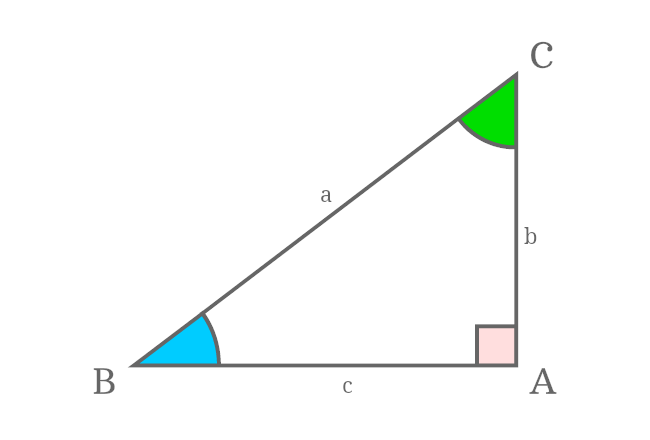

> Vypočítá rozdíl mezi elevací dvou bodů (b v obrázku), který použije pro získání sinu úhlu elevace (modrý úhel v obrázku) $\rightarrow$ návratová hodnota
<br>
> Zároveň vypočítá novou vzdálenost mezi body (a v obrázku), která uvažuje změnu v elevaci $\rightarrow$ návratová hodnota

In [10]:
def get_acceleration(points, max_velocity):   
    dist_values = [0]
    velocity_values = [0]
    acceleration_values = [0]
    angle_sin_values = [0]
    
    dist = 0
    velocity_reached = False
    for i in range(len(points)-1):
        immediate_distance = calc_distance_two_points(points[i], points[i+1])
        angle_sin, slope_distance = get_elevation_slope_sin_old(points[i], points[i+1], immediate_distance)
        angle_sin_values.append(angle_sin)
        dist += slope_distance
        if not velocity_reached:
            acceleration_values.append(TRAIN_ACC_MS2)
            velocity = calc_velocity(TRAIN_ACC_MS2, dist)
            if velocity >= max_velocity:
                velocity = max_velocity
                velocity_reached = True
        else:
            acceleration_values.append(0)
        dist_values.append(dist)
        velocity_values.append(velocity)
    return dist_values, velocity_values, acceleration_values, angle_sin_values

> Tato funkce dostane na vstupu body trati a maximální rychlost
<br>
> Pro každou po sobě jdoucí dvojici bodů se vypočítá/získá:
> - 2D vzdálenost
> - Vzdálenost s ohledem na změnu elevace + sinus úhlu spojeného s elevací
> - Rychlost na základě konstantního zrychlení
> - Zrychlení v daném bodě (možnosti: zrychlení / 0 / zpomalení)

> Kde se tento přístup jeví jako naivní:
> - Zrychlení je konstantní po celou dobu rozjezdu a při dosažení maximální rychlosti skočí na nulu
> - Vlak na začátku zrychluje a po dosažení maximální rychlosti na trati se jí perfektně drží
> - Tření je imaginární koncept

In [11]:
def get_deceleration(points, max_velocity):
    dist = 0
    end_velocity = [0]
    for i in range(len(points)-1,0,-1):
        dist = dist + calc_distance_two_points(points[i], points[i-1])
        velocity = calc_velocity(TRAIN_DEC_MS2, dist)
        if velocity >= max_velocity:
            break
        end_velocity.append(velocity)
    return end_velocity

> Tato funkce počítá pouze rychlost a to pro posledních několik metrů cesty
<br>
> Funguje obdobně jako předchozí a slouzí pouze k doplnění brždění vlaku

In [12]:
def get_complete_velocity(points, max_velocity):
    dist_values, velocity_values, acceleration_values, angle_sin_values = get_acceleration(points, max_velocity)
    end_velocity = get_deceleration(points, max_velocity)
    for i in range(len(end_velocity)):
        velocity_values[-i-1] = end_velocity[i]
        acceleration_values[-i-1] = -TRAIN_DEC_MS2
    return dist_values, velocity_values, acceleration_values, angle_sin_values

> Tato funkce pouze vezme hodnoty ze dvou předchozích a udělá z nich jeden celek
<br>
> Na konci je tedy mimo jiné možné vygenerovat graf rychlosti po celé trati, kde vlak nejdřívě zrychluje, potom urdžuje konstantní rychlost a následně zpomalí

In [13]:
def get_kinetic_energy(mass, velocity_values):
    return [calc_kinetic_energy(mass, v) for v in velocity_values]

> Tato funkce na vstupu dostane hmotnost a hodnoty rychlosti
<br>
> Vrátí pro každou hodnotu rychlosti hodnotu kinetické energie podle vzorce: $ E_K = \frac{1}{2}mv^2 $

In [14]:
def get_potential_energy(mass, points):
    return [calc_potential_energy(mass, p[2]) for p in points]

> Tato funkce na vstup dostane hmotnost a body trati
<br>
> Vrátí pro každou hodnotu výšky hodnotu potenciální energie podle vzorce $ E_P = mgh $ 

In [15]:
def get_normalized_potential_energy(potential_energy):
    return [e-potential_energy[0] for e in potential_energy]

> Tato funkce na vstup dostane hodnoty potenciální energie
<br>
> Vrátí hodnoty *normalizované* podle počáteční (protože je pro nás podstatná pouze relativní změna)

In [16]:
def get_work(energy_values):
    return [energy_values[i+1]-x for i,x in enumerate(energy_values) if i < len(energy_values)-1]

> Tato funkce na vstupu dostane hodnoty energie
<br>
> Vrátí pro každou dvojici na indexu *i* a *i+1* hodnotu vykonané práce podle vzorce: $ W = \Delta E = E_{i+1} - E_{i} $
<br>
> **Poznámka:** Aktuálně se nepoužívá

In [17]:
def get_power(mass, acceleration_values, angle_sin_values, velocity_values):
    return [(mass*a + mass*G_TO_MS2*angle_sin_values[i])*velocity_values[i] for i,a in enumerate(acceleration_values)]

> Tato funkce na vstupu dostane hmotnost, hodnoty zrychlení, hodnoty sinů úhlů sklonu při elevaci a hodnoty rychlosti
<br>
> Vrátí list hodnot výkonu, kdy každou hodnotu v něm vypočítá podle tohoto vzorce: $ P = Fv = (F_{Lokomotiva} + F_{Gravitace})v = (ma + mg\sin{\alpha})v $

In [18]:
def draw_plot(dist_values, highlight_zero, args):
    fig=plt.figure(figsize=(20,4), dpi= 100)
    plt.xlabel("Vzdálenost (m)")
    if highlight_zero:
        plt.axhline(y=0, color="grey", linestyle="dotted")
    if "stations" in args:
        plt.plot(dist_values, args["values"], "-D", label=args["name"], markevery=args["stations"])
    elif "scatter" in args and args["scatter"]:
        plt.scatter(dist_values, args["values"], label=args["name"], marker="o")
    else:
        plt.plot(dist_values, args["values"], label=args["name"])
    if "limit_values" in args:
        plt.plot(dist_values, args["limit_values"], linestyle="dotted", label=args["limit_name"])
    plt.legend()
    plt.show()

## Spuštění testovacího případu

Aktuálně je nutné vložit jako vstup trať, která má každé dva sousední body ekvidistantní (což pro původní SŽ data neplatí).
<br>
Výběr takových bodů by mělo být možné pomocí PostGISu uskutečnit. Zatím práce s exportem z programu QGIS, který tuto funkcionalitu nabízí.

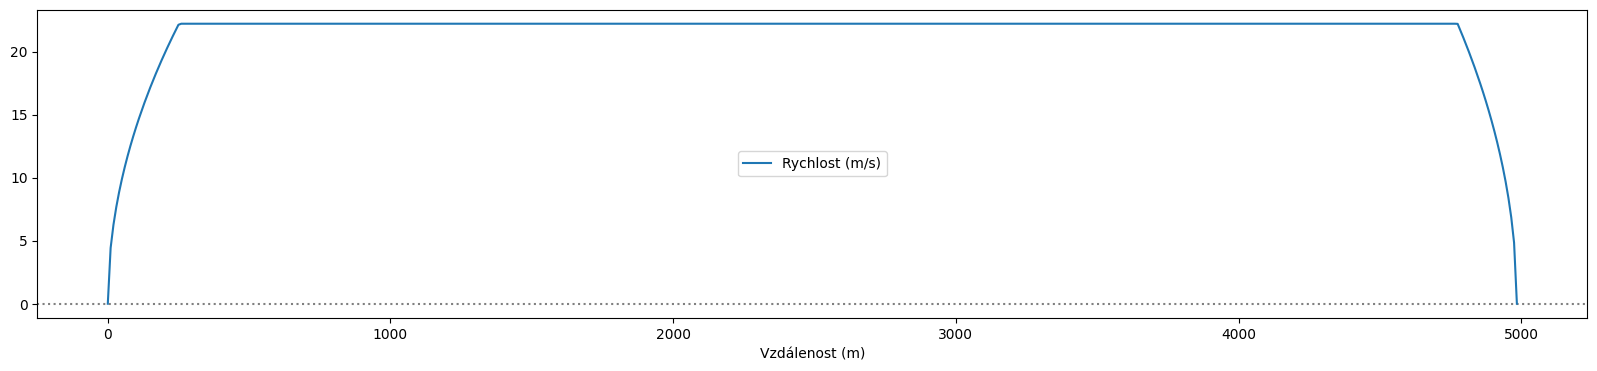

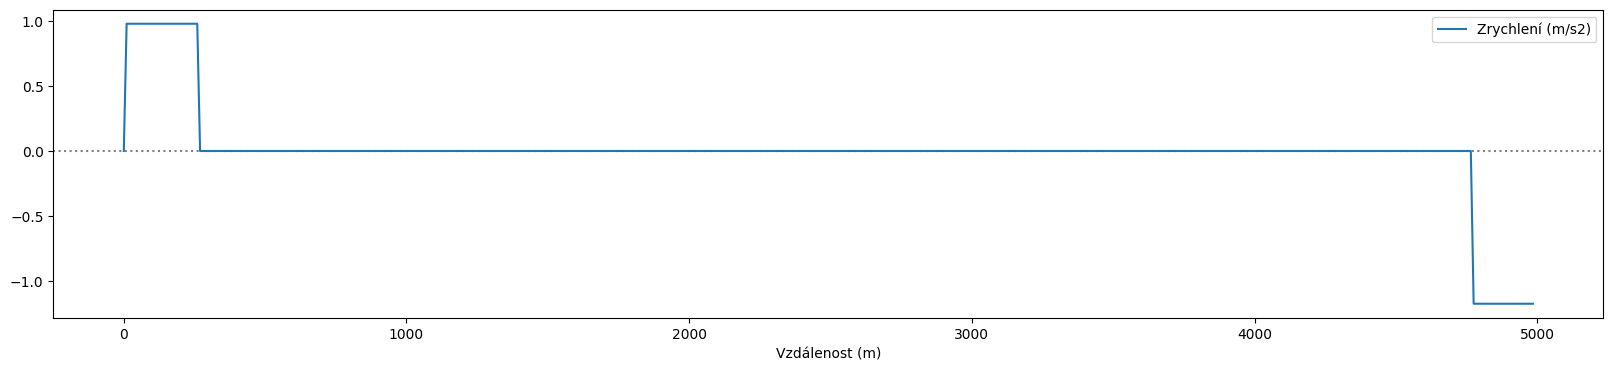

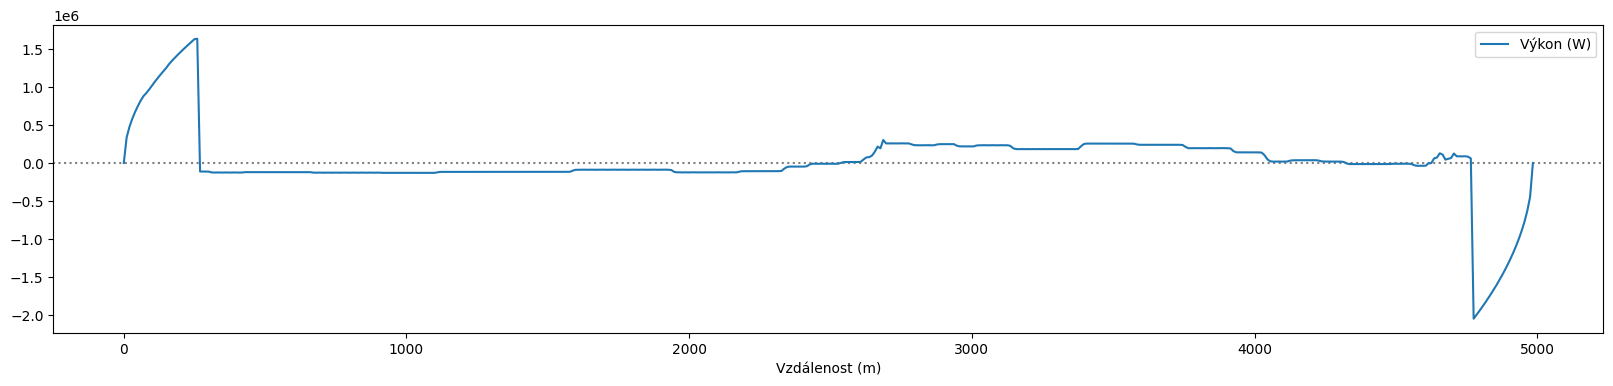

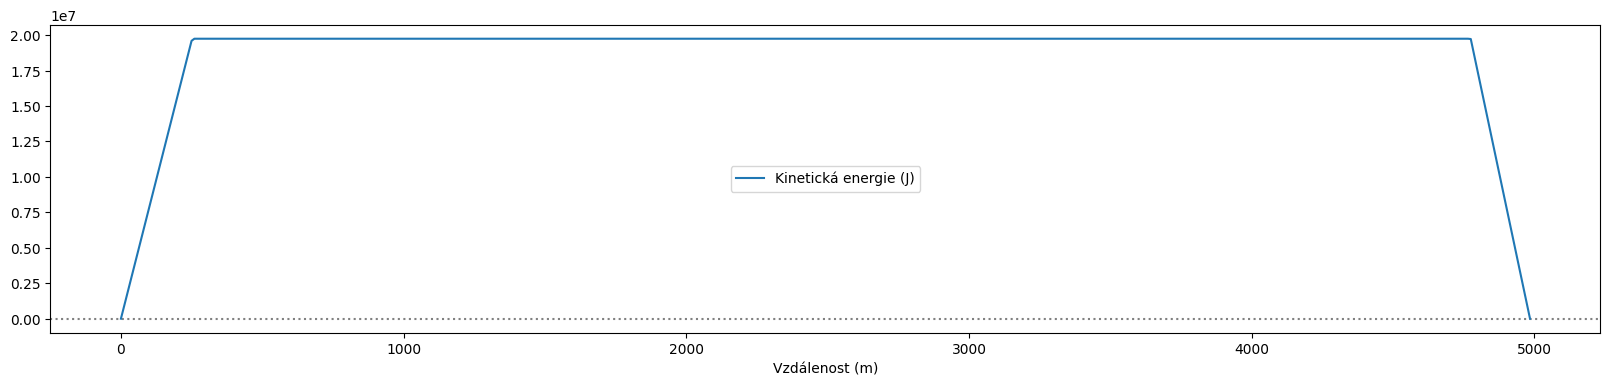

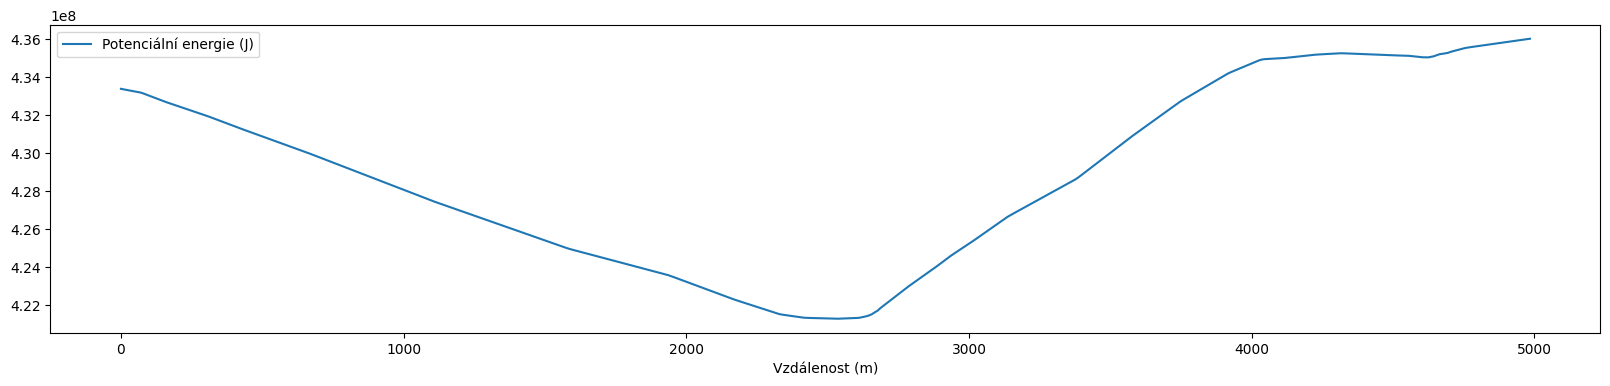

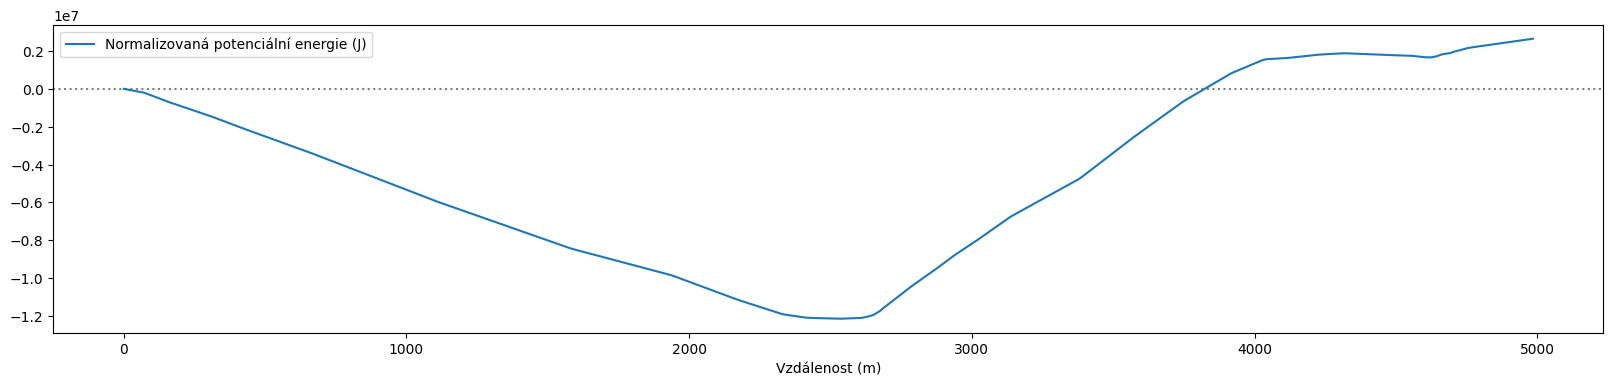

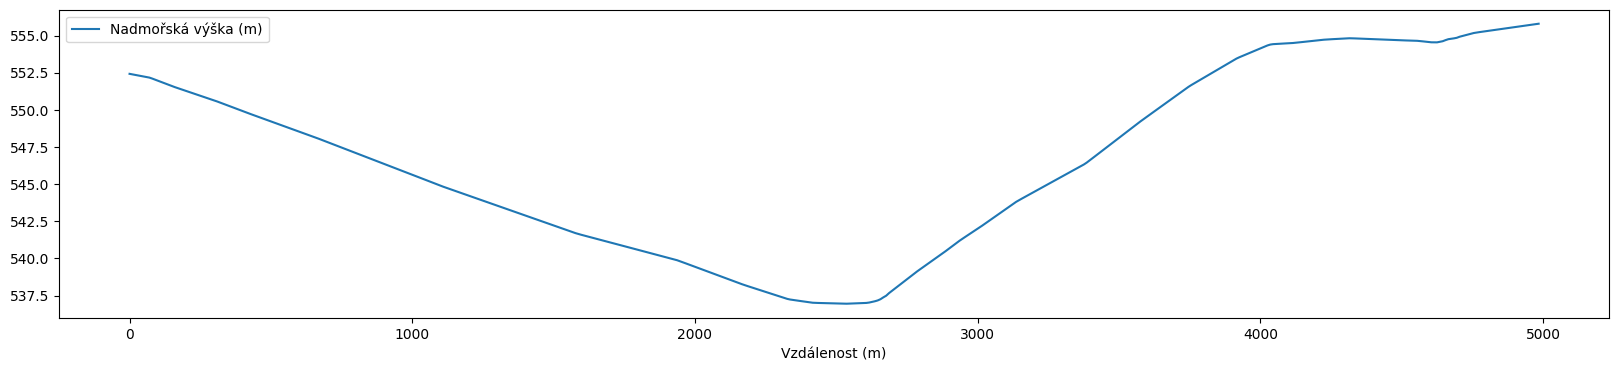

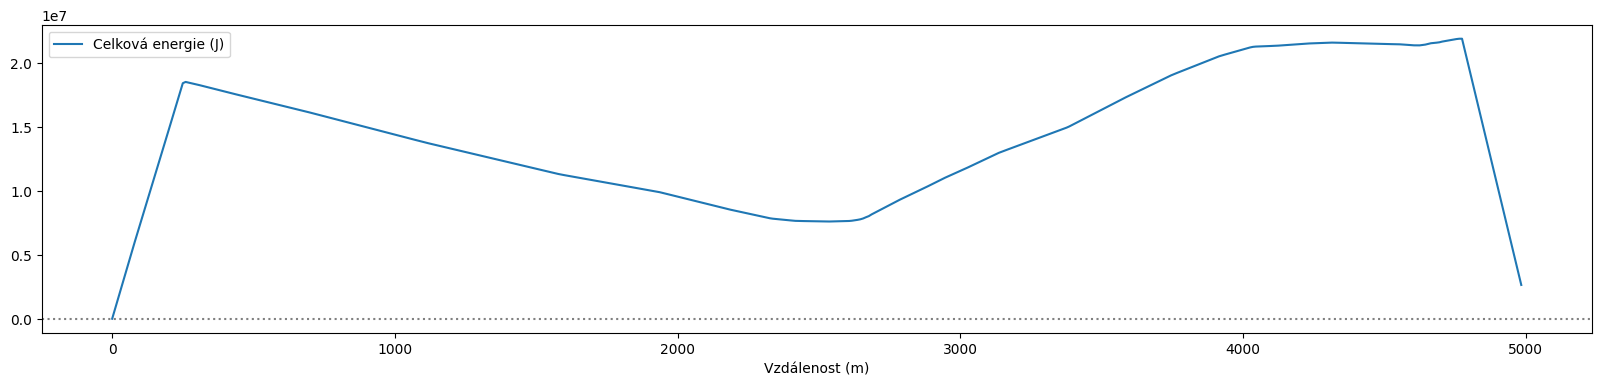

In [19]:
with open("spaced.geojson") as f:
    lines = f.readlines()
    points = parse_points_from_geojson("".join(lines))
    # Remove zeros
    for i in range(len(points)):
        if i == 0:
            continue
        if points[i][2] < points[i-1][2]*0.9:
            points[i] = [points[i][0],points[i][1],points[i-1][2]]

# Show only part of the track
points = points[6000:6500]
# points = [[x[0], x[1], 100] for x in points]
# print(len(points))

max_velocity = 22.22 # m/s
mass = 80000 # kg

dist_values, velocity_values, acceleration_values, angle_sin_values = get_complete_velocity(points, max_velocity)
k_energy_values = get_kinetic_energy(mass, velocity_values)
p_energy_values = get_potential_energy(mass, points)
norm_p_energy_values = get_normalized_potential_energy(p_energy_values) 
power_values = get_power(mass, acceleration_values, angle_sin_values, velocity_values)

# Plots
draw_plot(dist_values, True, {"values": velocity_values, "name": "Rychlost (m/s)", "scatter": False})
draw_plot(dist_values, True, {"values": acceleration_values, "name": "Zrychlení (m/s2)", "scatter": False})
draw_plot(dist_values, True, {"values": power_values, "name": "Výkon (W)", "scatter": False})
draw_plot(dist_values, True, {"values": k_energy_values, "name": "Kinetická energie (J)", "scatter": False})
draw_plot(dist_values, False, {"values": p_energy_values, "name": "Potenciální energie (J)", "scatter": False})
draw_plot(dist_values, True, {"values": norm_p_energy_values, "name": "Normalizovaná potenciální energie (J)", "scatter": False})
draw_plot(dist_values, False, {"values": [x[2] for x in points], "name": "Nadmořská výška (m)", "scatter": False})
draw_plot(dist_values, True, {"values": [k_energy_values[i]+norm_p_energy_values[i] for i in range(len(k_energy_values))], "name": "Celková energie (J)", "scatter": False})

## Závěrečné poznámky k první iteraci

Takto vypadá můj dosavadní průzkum. Všechno to stojí na velmi základních vzorcích. Ale za předpokladu, že jsou moje pochody o tom, jak věci fungují, alespoň trochu správné, tak by to pro začátek mohlo stačit.
<br>
Narazil jsem na odbornou práci, která se věnuje metodologii odhadování vlakové spotřeby, ale zatím nejsem schopen ani začít uvažovat o tom, jak se do něčeho takového ponořit. Přikládám [ODKAZ](https://mdpi-res.com/d_attachment/energies/energies-15-04256/article_deploy/energies-15-04256-v2.pdf?version=1654851864) pro případnou budoucí referenci.
<br>
A nakonec si tady ještě odložím jeden zdroj (odkaz [ZDE](http://evilgeniustech.com/idiotsGuideToRailroadPhysics/)), který jsem sice nepoužil, ale pokud dojde na studium dokumentace a dolování konkrétních parametrů lokomotiv, tak by se mohl hodit.

<br>
<hr>
<br>
<a id="druha_iterace"></a>

## Druhá iterace - Počítání s adhezí (6.2.2023)
<a href="#teleport">
    <button>Zpět na teleport</button>
</a>

### Zdroje
> https://web.archive.org/web/20200526222719/http://www.kves.uniza.sk/kvesnew/dokumenty/et/ET%20skripta%20Danzer/ETR700.pdf
<br>
> https://www.youtube.com/watch?v=cPMSMDSY-rc

### Plán
- Vypočítat tečnou sílu ✅
- Odečíst/přičíst sílu působící směrem dolů z nakloněné roviny (působení gravitace) ✅
- Limitovat výsledky výkonem lokomotivy (maximální limit zrychlení) ✅ (Funkce tento vstup akceptují, ale v příkladu se nepoužívá)

### Poznámky k řešení:
- <s>Zrychlení končí na hodnotě *0* (podezřelé)</s>
- <s>Obrázek ilustrující kombinované síly chybí</s>

### Úvahy pro příští iterace:
- Limitem, kterého bychom se měli při výpočtech simulujících realitu držet, možná není pouze ten maximální technický - určité zrychlení může např. snižovat jízdní komfort a proto se nepoužívá, byť je technicky dosažitelné (teorie)

### Vzorce

In [20]:
def calc_normal_force(mass, angle_cos):
    return mass*G_TO_MS2*angle_cos

> Vzorec pro výpočet normální síly: $ F_N = mg\cos\alpha $

In [21]:
def calc_parallel_g_force(mass, angle_sin):
    return mass*G_TO_MS2*angle_sin

> Vzorec pro výpočet složky gravitační síly rovnoběžné s povrchem nakloněné roviny: $ F_{||} = mg\sin\alpha $

In [22]:
def calc_adhesion_ck(velocity):
    return 7500/(velocity+44)+161 #μ_max

> Empirický vzorec pro výpočet maximálního koeficientu adheze (Curtius-Kniffler): $ \mu_{MAX} = \frac{7500}{v+44}+161 $

In [23]:
def calc_tangential_force(mass, angle_cos, velocity):
    velocity_in_kph = velocity*3.6
    normal_force_in_kn = calc_normal_force(mass, angle_cos)/1000
    return normal_force_in_kn*calc_adhesion_ck(velocity_in_kph)

> Vzorec pro výpočet tečné síly působící na nápravu. Vznikl dosazením některých předchozích vzorců do rovnice pro koeficient adheze (1):
<br>
> 1. $ \mu_{MAX} = \frac{T_{MAX}}{N} \rightarrow T_{MAX} = N\mu_{MAX}$
<br>
> 2. $ \mu_{MAX} = \frac{7500}{v+44}+161 $
<br>
> 3. $ N = mg\cos\alpha $
<br>
<br>
Dosazení:
<br>
> $ T_{MAX} = mg\cos\alpha\cdot \left(\frac{7500}{v+44}+161\right) $

<hr>

### Intermezzo: Grafický popis sil

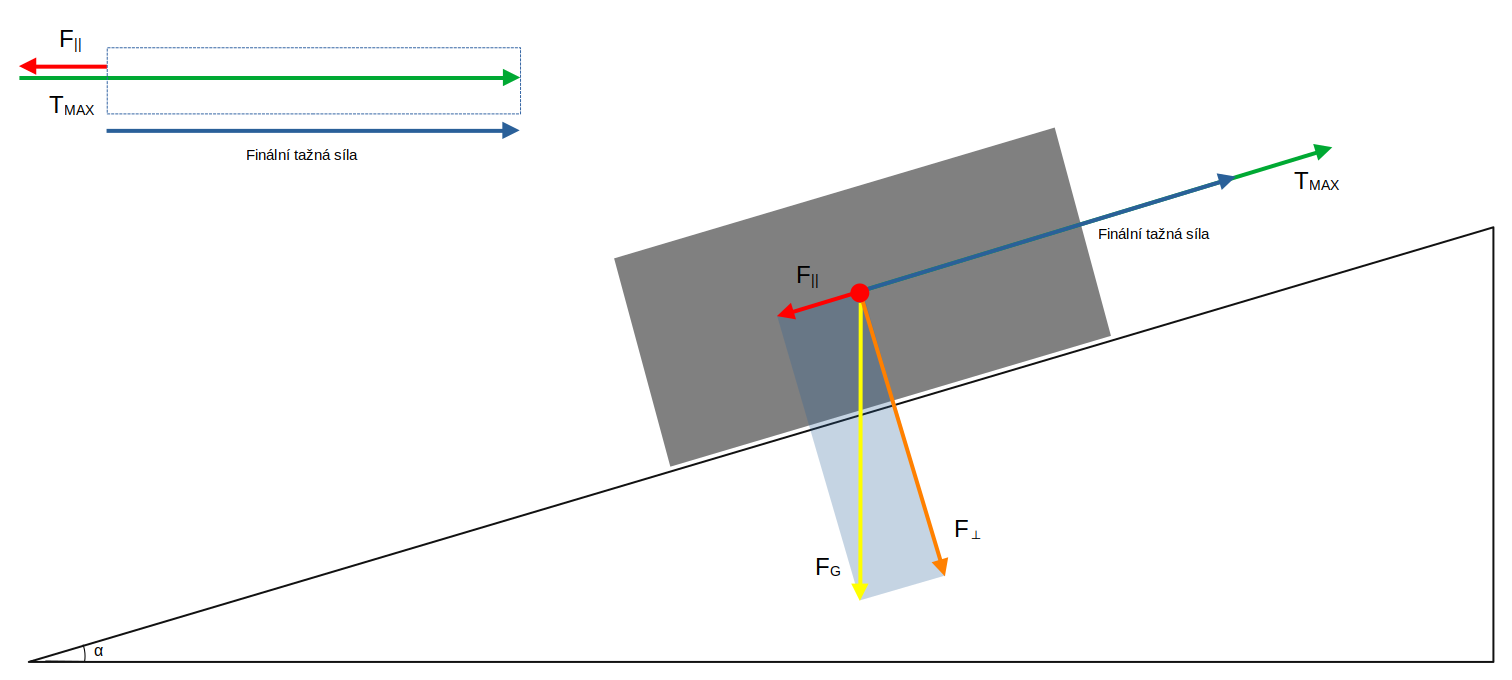

<hr>

In [24]:
def calc_acceleration(force, mass):
    return force/mass

> Vzorec pro výpočet zrychlení: $ a = \frac{F}{m} $

In [25]:
def get_elevation_slope_sin(point_a, point_b, dist):
    elevation_delta = abs(point_b[2] - point_a[2])
    slope_distance = math.sqrt(elevation_delta**2 + dist**2)
    return elevation_delta/slope_distance, slope_distance

def get_elevation_slope_cos(point_a, point_b, dist):
    elevation_delta = point_b[2] - point_a[2]
    slope_distance = math.sqrt(elevation_delta**2 + dist**2)
    return dist/slope_distance, slope_distance

> Tyto funkce vezmou dva body a vzdálenost mezi nimi

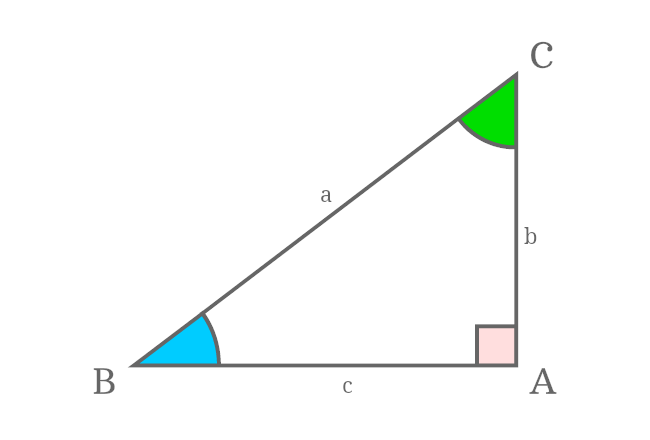

> Vypočítají rozdíl mezi elevací dvou bodů (b v obrázku), který použijí pro získání sinu/cosinu úhlu elevace (modrý úhel v obrázku) $\rightarrow$ návratová hodnota
<br>
> Zároveň vypočítají novou vzdálenost mezi body (a v obrázku), která uvažuje změnu v elevaci $\rightarrow$ návratová hodnota

In [26]:
def get_ramp_up(mass, points, max_velocity, acceleration_limit=None):
    force_values = [0]
    velocity_values = [0]
    dist_values = [0]
    acceleration_values = [0]
    velocity_reached = False
    
    for i in range(len(points)-1):
        immediate_distance = calc_distance_two_points(points[i], points[i+1])
        angle_cos, slope_distance = get_elevation_slope_cos(points[i], points[i+1], immediate_distance)
        tangential_force = calc_tangential_force(mass, angle_cos, velocity_values[-1])
        angle_sin = get_elevation_slope_sin(points[i], points[i+1], immediate_distance)[0]
        parallel_g_force = calc_parallel_g_force(mass, angle_sin)
        
        if not velocity_reached:
            # Is it incline/decline?
            if points[i+1][2] - points[i][2] > 0: # Incline
                final_force = tangential_force - parallel_g_force
            else: # Decline
                final_force = tangential_force + parallel_g_force
            acceleration = calc_acceleration(final_force, mass)
            # NOTE: If acceleration exceeds the limit, we'll just cap it
            if acceleration_limit is not None and acceleration > acceleration_limit:
                acceleration = acceleration_limit
            new_velocity = calc_velocity(acceleration, slope_distance, velocity_values[-1])
            if new_velocity >= max_velocity:
                new_velocity = max_velocity
                velocity_reached = True
        else:
            # Correction: when surface is not flat, we need to exert force to keep our speed
            # Is it incline/decline?
            if points[i+1][2] - points[i][2] > 0: # Incline
                final_force = parallel_g_force
            else: # Decline
                final_force = -parallel_g_force
            acceleration = 0 # NOTE: If no change in speed, acceleration is ZERO
        force_values.append(final_force)
        velocity_values.append(new_velocity)
        dist_values.append(dist_values[-1]+slope_distance)
        acceleration_values.append(acceleration)
    return force_values, dist_values, velocity_values, acceleration_values

> Tato funkce dostane na vstupu hmotnost vozidla, body trati, maximální rychlost a limit zrychlení, který nesmí být překročen
<br>
> Pro každou po sobě jdoucí dvojici bodů se vypočítá/získá:
> - 2D vzdálenost
> - Vzdálenost s ohledem na změnu elevace + sinus a cosinus úhlu spojeného s elevací
> - Tečná síla působící na nápravu a síla vznikající vlivem gravitace působící rovnoběžně s povrchem $\rightarrow$ to dá součtem/rozdílem maximální sílu působící na rozjezd vlaku
> - Zrychlení v daném bodě
> - Rychlost na základě získaného zrychlení

> Kde se tento přístup jeví jako naivní (**aktualizace z první iterace**):
> - <s>Zrychlení je konstantní po celou dobu rozjezdu a při dosažení maximální rychlosti skočí na nulu</s> $\rightarrow$ Při dosažení maximální rychlosti stále skočí na nulu (nedochází ke změně rychlosti), ale už není konstantní při rozjezdu/brždění
> - Tažná sílá se počítá z celé hmotnosti
> - Vlak na začátku zrychluje a po dosažení maximální rychlosti na trati se jí perfektně drží
> - Tření je imaginární koncept

In [27]:
def get_ramp_down(mass, points, max_velocity, acceleration_limit=None):
    end_force = [0]
    end_velocity = [0]
    deceleration_values = [0]
    for i in range(len(points)-1,0,-1):
        immediate_distance = calc_distance_two_points(points[i], points[i-1])
        
        angle_cos, slope_distance = get_elevation_slope_cos(points[i-1], points[i], immediate_distance)
        tangential_force = calc_tangential_force(mass, angle_cos, end_velocity[-1])
        angle_sin = get_elevation_slope_sin(points[i-1], points[i], immediate_distance)[0]
        parallel_g_force = calc_parallel_g_force(mass, angle_sin)
        
        # Is it incline/decline?
        if points[i-1][2] - points[i][2] > 0: # Incline
            final_force = tangential_force - parallel_g_force
        else: # Decline
            final_force = tangential_force + parallel_g_force
        acceleration = calc_acceleration(final_force, mass)
        # NOTE: If acceleration exceeds the limit, we'll just cap it
        if acceleration_limit is not None and acceleration > acceleration_limit:
            acceleration = acceleration_limit
        new_velocity = calc_velocity(acceleration, slope_distance, end_velocity[-1])
        if new_velocity >= max_velocity:
            deceleration_values.append(-acceleration) # NOTE: Deceleration has opposite direction
            break
        end_force.append(-final_force) # NOTE: Braking force has opposite direction
        end_velocity.append(new_velocity)
        deceleration_values.append(-acceleration) # NOTE: Deceleration has opposite direction
    return end_force, end_velocity, deceleration_values[1::]

> Tato funkce počítá působící sílu (kombinace maximální tečné síly a složky gravitační síly), rychlost a zrychlení (resp. *zpomalení*) a to pro posledních několik metrů cesty
<br>
> Funguje obdobně jako předchozí a slouzí pouze k doplnění brždění vlaku

In [28]:
def get_complete_run(mass, points, max_velocity, acceleration_limit=None):
    force_values, dist_values, velocity_values, acceleration_values = get_ramp_up(mass, points, max_velocity, acceleration_limit)
    end_force, end_velocity, deceleration_values = get_ramp_down(mass, points, max_velocity, acceleration_limit)
    for i in range(len(end_velocity)):
        force_values[-i-1] = end_force[i]
        velocity_values[-i-1] = end_velocity[i]
        acceleration_values[-i-1] = deceleration_values[i]
    return force_values, dist_values, velocity_values, acceleration_values

> Tato funkce pouze vezme hodnoty ze dvou předchozích a udělá z nich jeden celek
<br>
> Na konci je tedy mimo jiné možné vygenerovat graf rychlosti po celé trati, kde vlak nejdřívě zrychluje, potom urdžuje konstantní rychlost a následně zpomalí

In [29]:
def get_power_raw(force_values, velocity_values):
    return [force_values[i]*velocity_values[i] for i in range(len(force_values))]

> Tato funkce na vstupu dostane hodnoty působící síly a hodnoty rychlosti v jednotlivých bodech trati
<br>
> Vrátí list hodnot výkonu, kdy každou hodnotu v něm vypočítá podle tohoto vzorce: $ P = Fv $

## Spuštění testovacího případu

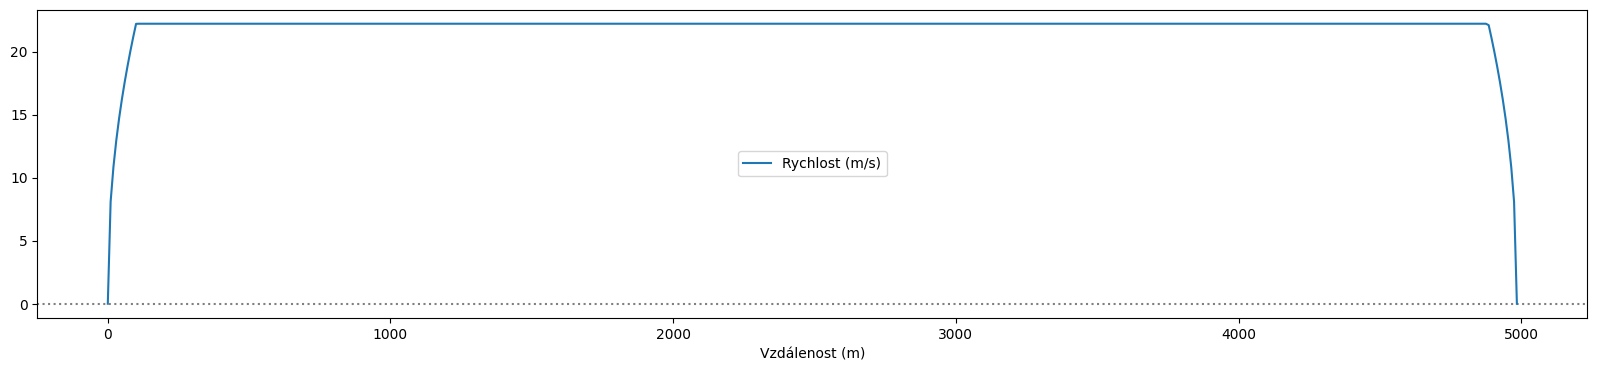

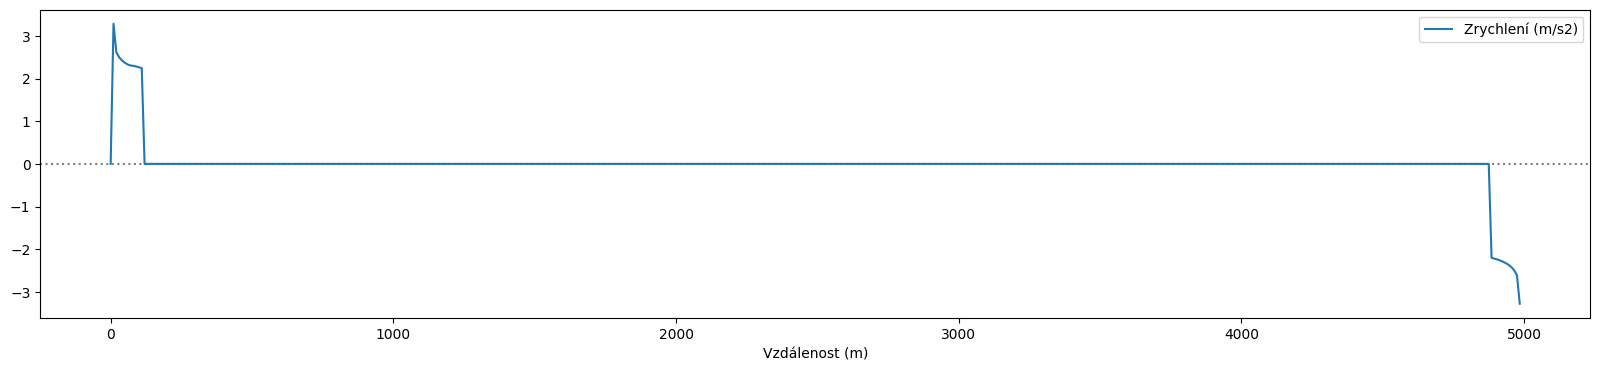

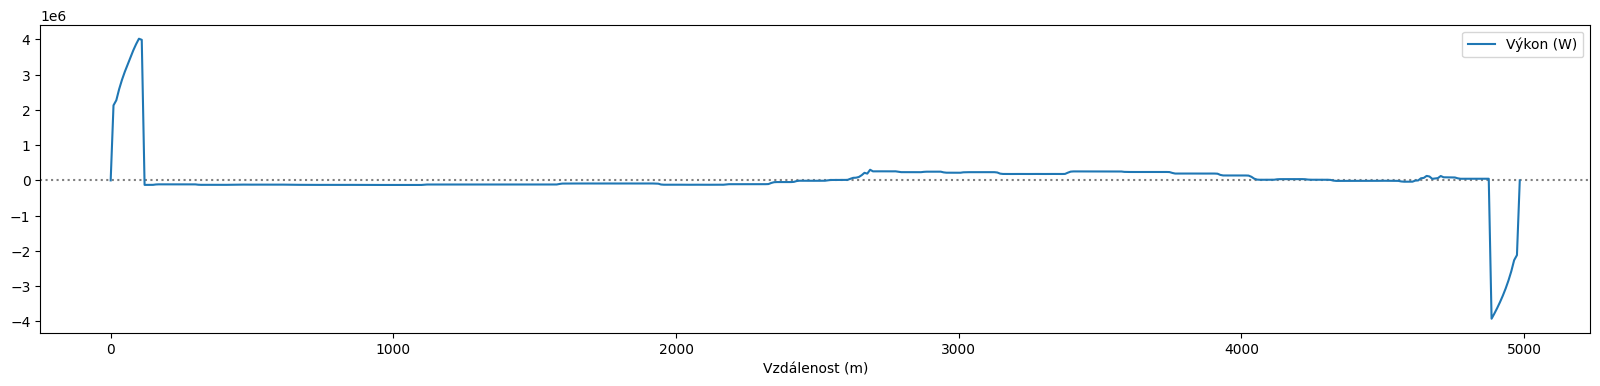

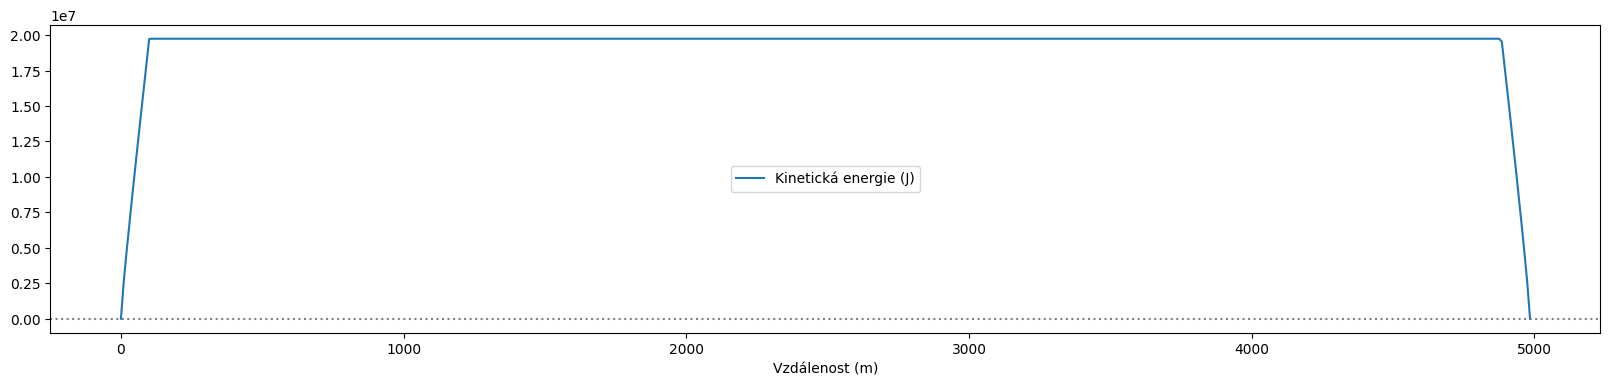

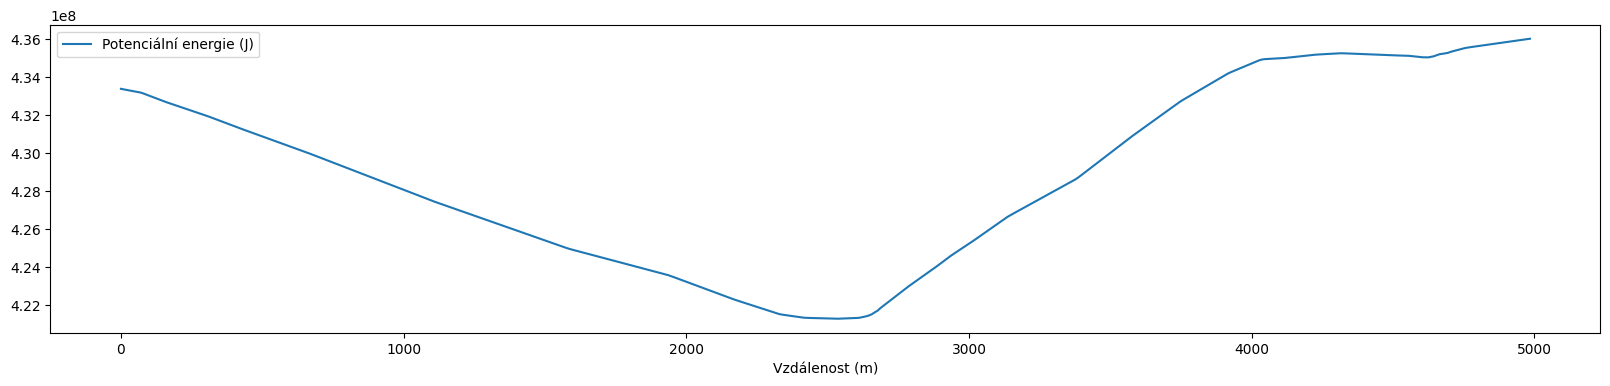

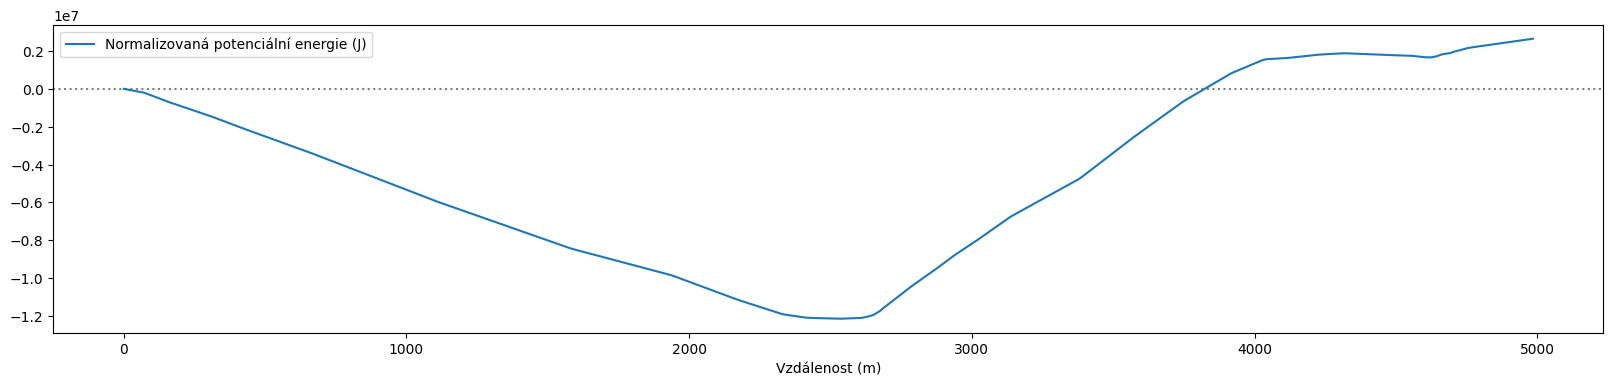

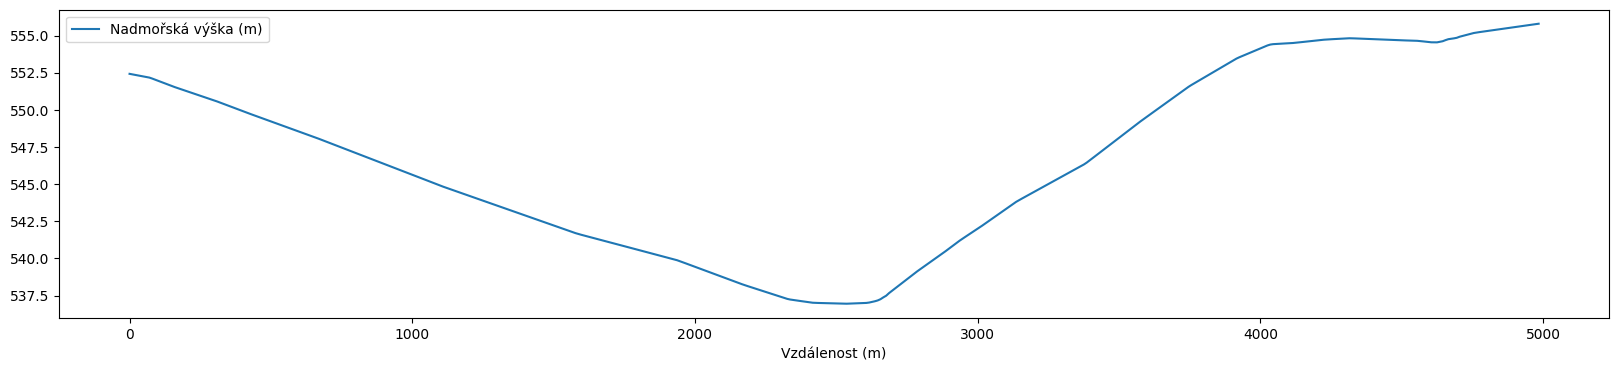

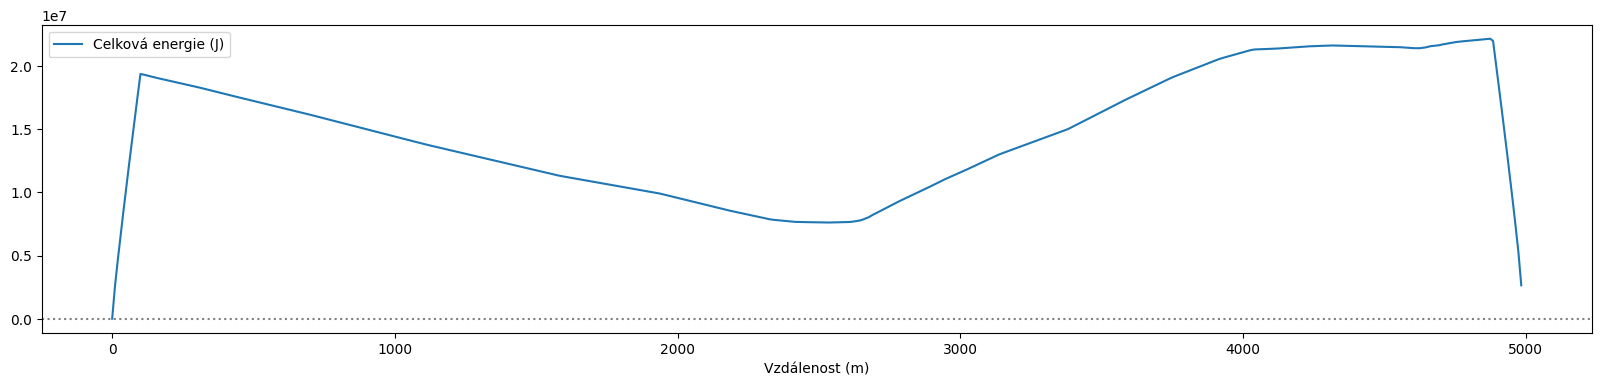

In [30]:
with open("spaced.geojson") as f:
    lines = f.readlines()
    points = parse_points_from_geojson("".join(lines))
    # Remove zeros
    for i in range(len(points)):
        if i == 0:
            continue
        if points[i][2] < points[i-1][2]*0.9:
            points[i] = [points[i][0],points[i][1],points[i-1][2]]

# Show only part of the track
points = points[6000:6500]

max_velocity = 22.22 # m/s
mass = 80000 # kg
force_values, dist_values, velocity_values, acceleration_values = get_complete_run(mass, points, max_velocity)
power_values = get_power_raw(force_values, velocity_values)
k_energy_values = get_kinetic_energy(mass, velocity_values)
p_energy_values = get_potential_energy(mass, points)
norm_p_energy_values = get_normalized_potential_energy(p_energy_values)

draw_plot(dist_values, True, {"values": velocity_values, "name": "Rychlost (m/s)", "scatter": False})
draw_plot(dist_values, True, {"values": acceleration_values, "name": "Zrychlení (m/s2)", "scatter": False})
draw_plot(dist_values, True, {"values": power_values, "name": "Výkon (W)", "scatter": False})
draw_plot(dist_values, True, {"values": k_energy_values, "name": "Kinetická energie (J)", "scatter": False})
draw_plot(dist_values, False, {"values": p_energy_values, "name": "Potenciální energie (J)", "scatter": False})
draw_plot(dist_values, True, {"values": norm_p_energy_values, "name": "Normalizovaná potenciální energie (J)", "scatter": False})
draw_plot(dist_values, False, {"values": [x[2] for x in points], "name": "Nadmořská výška (m)", "scatter": False})
draw_plot(dist_values, True, {"values": [k_energy_values[i]+norm_p_energy_values[i] for i in range(len(k_energy_values))], "name": "Celková energie (J)", "scatter": False})

## Závěrečné poznámky k druhé iteraci

Funkce z první iterace jsem změnil podle návrhů na zakomponování adheze, které byly diskutovány jak na pondělní shůzce, tak dále přes e-mail.
<br>
Fungování sil, jak s nimi počítám, jsem se pokusil u implementace rozkreslit. Opět netvrdím, že je to uchopeno 100% správně, takže očekávám případné korekce a návrhy na zlepšení.
<br>
**Příští zastávka:** jízdní odpory

<br>
<hr>
<br>
<a id="treti_iterace"></a>

## Třetí iterace - Počítání s vagóny (8.2.2023)

<a href="#teleport">
    <button>Zpět na teleport</button>
</a>

### Plán
- Přidat hmotnost (vagóny), na kterou působí pouze gravitační síla, ale už ne adheze ✅

In [31]:
def get_ramp_up_sep(mass_locomotive, mass_wagon, points, max_velocity, acceleration_limit=None):
    force_values = [0]
    velocity_values = [0]
    dist_values = [0]
    acceleration_values = [0]
    velocity_reached = False
    
    for i in range(len(points)-1):
        immediate_distance = calc_distance_two_points(points[i], points[i+1])
        angle_cos, slope_distance = get_elevation_slope_cos(points[i], points[i+1], immediate_distance)
        angle_sin = get_elevation_slope_sin(points[i], points[i+1], immediate_distance)[0]
        
        # Forces on locomotive
        tangential_force_l = calc_tangential_force(mass_locomotive, angle_cos, velocity_values[-1])
        parallel_g_force_l = calc_parallel_g_force(mass_locomotive, angle_sin)
        
        # Forces on wagon
        parallel_g_force_w = calc_parallel_g_force(mass_wagon, angle_sin)
        
        if not velocity_reached:
            # Is it incline/decline?
            if points[i+1][2] - points[i][2] > 0: # Incline
                final_force = tangential_force_l - parallel_g_force_l - parallel_g_force_w
            else: # Decline
                final_force = tangential_force_l + parallel_g_force_l + parallel_g_force_w
            acceleration = calc_acceleration(final_force, mass_locomotive+mass_wagon)
            # NOTE: If acceleration exceeds the limit, we'll just cap it
            # TODO: Check if we can cap acceleration from tangential force separately
            if acceleration_limit is not None and acceleration > acceleration_limit:
                acceleration = acceleration_limit
            new_velocity = calc_velocity(acceleration, slope_distance, velocity_values[-1])
            if new_velocity >= max_velocity:
                new_velocity = max_velocity
                velocity_reached = True
        else:
            # Correction: when surface is not flat, we need to exert force to keep our speed
            # Is it incline/decline?
            if points[i+1][2] - points[i][2] > 0: # Incline
                final_force = parallel_g_force_l + parallel_g_force_w
            else: # Decline
                final_force = -parallel_g_force_l - parallel_g_force_w
            acceleration = 0 # NOTE: If no change in speed, acceleration is ZERO
        force_values.append(final_force)
        velocity_values.append(new_velocity)
        dist_values.append(dist_values[-1]+slope_distance)
        acceleration_values.append(acceleration)
    return force_values, dist_values, velocity_values, acceleration_values

> Tato funkce dostane na vstupu hmotnost lokomotivy, body trati, maximální rychlost a limit zrychlení, který nesmí být překročen
<br>
> Pro každou po sobě jdoucí dvojici bodů se vypočítá/získá:
> - 2D vzdálenost
> - Vzdálenost s ohledem na změnu elevace + sinus a cosinus úhlu spojeného s elevací
> - Tečná síla působící na nápravu lokomotivy a síla vznikající vlivem gravitace působící rovnoběžně s povrchem (pro lokomotivu i vagóny) $\rightarrow$ to dá součtem/rozdílem maximální sílu působící na rozjezd vlaku
> - Zrychlení v daném bodě
> - Rychlost na základě získaného zrychlení

> Kde se tento přístup jeví jako naivní (**aktualizace z druhé iterace**):
> - <s>Zrychlení je konstantní po celou dobu rozjezdu a při dosažení maximální rychlosti skočí na nulu</s> $\rightarrow$ Při dosažení maximální rychlosti stále skočí na nulu (nedochází ke změně rychlosti), ale už není konstantní při rozjezdu/brždění
> - <s>Tažná sílá se počítá z celé hmotnosti</s> $\rightarrow$ Hmotnost je rozdělena na lokomotivu, pro kterou se tažná síla počítá, a na vagóny, u kterých se počítá pouze vliv gravitačního zrychlení
> - Vlak na začátku zrychluje a po dosažení maximální rychlosti na trati se jí perfektně drží
> - Tření je imaginární koncept

In [32]:
def get_ramp_down_sep(mass_locomotive, mass_wagon, points, max_velocity, acceleration_limit=None):
    end_force = [0]
    end_velocity = [0]
    deceleration_values = [0]
    for i in range(len(points)-1,0,-1):
        immediate_distance = calc_distance_two_points(points[i], points[i-1])
        angle_cos, slope_distance = get_elevation_slope_cos(points[i-1], points[i], immediate_distance)
        angle_sin = get_elevation_slope_sin(points[i-1], points[i], immediate_distance)[0]
        
        # Forces on locomotive
        tangential_force_l = calc_tangential_force(mass_locomotive, angle_cos, end_velocity[-1])
        parallel_g_force_l = calc_parallel_g_force(mass_locomotive, angle_sin)
        
        # Forces on wagon
        parallel_g_force_w = calc_parallel_g_force(mass_wagon, angle_sin)
        
        # Is it incline/decline?
        if points[i-1][2] - points[i][2] > 0: # Incline
            final_force = tangential_force_l - parallel_g_force_l - parallel_g_force_w
        else: # Decline
            final_force = tangential_force_l + parallel_g_force_l + parallel_g_force_w
        acceleration = calc_acceleration(final_force, mass_locomotive+mass_wagon)
        # NOTE: If acceleration exceeds the limit, we'll just cap it
        if acceleration_limit is not None and acceleration > acceleration_limit:
            acceleration = acceleration_limit
        new_velocity = calc_velocity(acceleration, slope_distance, end_velocity[-1])
        if new_velocity >= max_velocity:
            deceleration_values.append(-acceleration) # NOTE: Deceleration has opposite direction
            break
        end_force.append(-final_force) # NOTE: Braking force has opposite direction
        end_velocity.append(new_velocity)
        deceleration_values.append(-acceleration) # NOTE: Deceleration has opposite direction
    return end_force, end_velocity, deceleration_values[1::]

> Tato funkce počítá působící sílu (kombinace maximální tečné síly a složky gravitační síly a u vagónu pouze gravitační síla), rychlost a zrychlení (resp. *zpomalení*) a to pro posledních několik metrů cesty
<br>
> Funguje obdobně jako předchozí a slouzí pouze k doplnění brždění vlaku

> Kde se tento přístup jeví jako naivní:
> - Rozjíždění tady funguje stejně jako zpomalování - typicky na brždění působí více náprav, zatímco u rozjezdu tlačí vlak pouze lokomotiva (jedna nebo více)

In [33]:
def get_complete_run_sep(mass_locomotive, mass_wagon, points, max_velocity, acceleration_limit=None):
    force_values, dist_values, velocity_values, acceleration_values = get_ramp_up_sep(mass_locomotive, mass_wagon, points, max_velocity, acceleration_limit)
    end_force, end_velocity, deceleration_values = get_ramp_down_sep(mass_locomotive, mass_wagon, points, max_velocity, acceleration_limit)
    for i in range(len(end_velocity)):
        force_values[-i-1] = end_force[i]
        velocity_values[-i-1] = end_velocity[i]
        acceleration_values[-i-1] = deceleration_values[i]
    return force_values, dist_values, velocity_values, acceleration_values

> Tato funkce pouze vezme hodnoty ze dvou předchozích a udělá z nich jeden celek
<br>
> Na konci je tedy mimo jiné možné vygenerovat graf rychlosti po celé trati, kde vlak nejdřívě zrychluje, potom urdžuje konstantní rychlost a následně zpomalí

## Spuštění testovacího případu

### Normální průběh

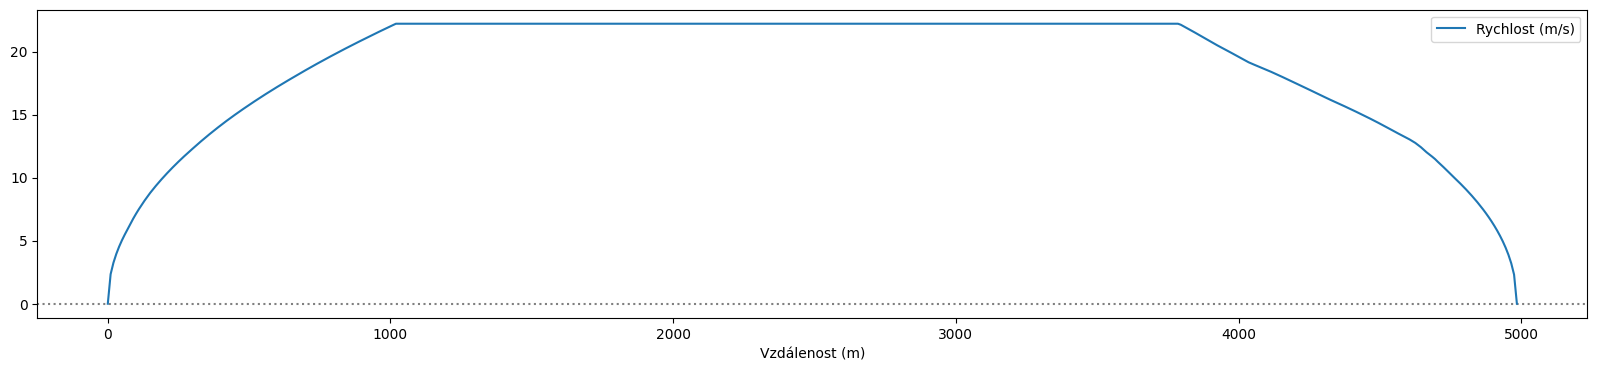

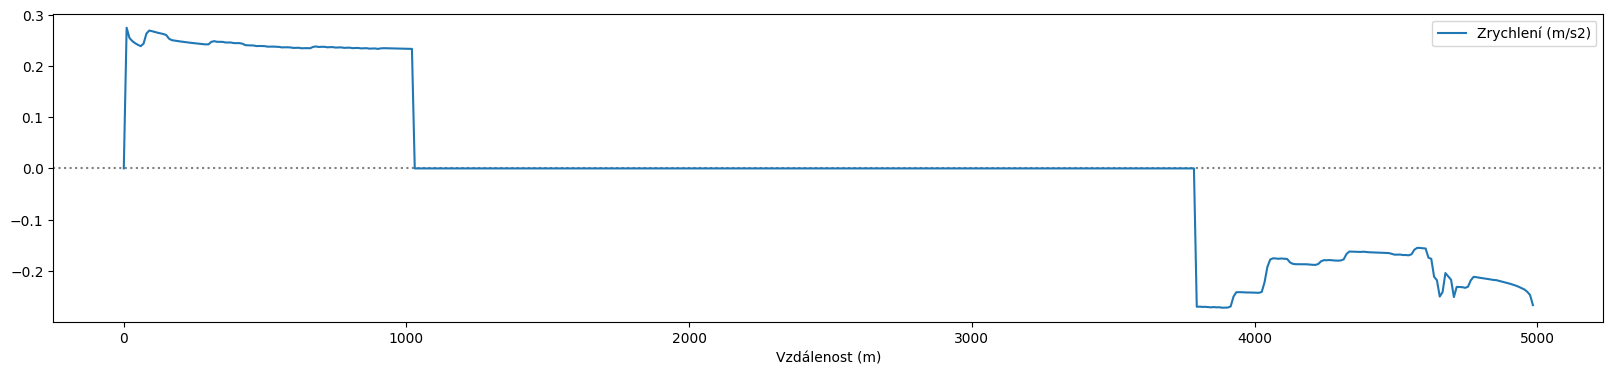

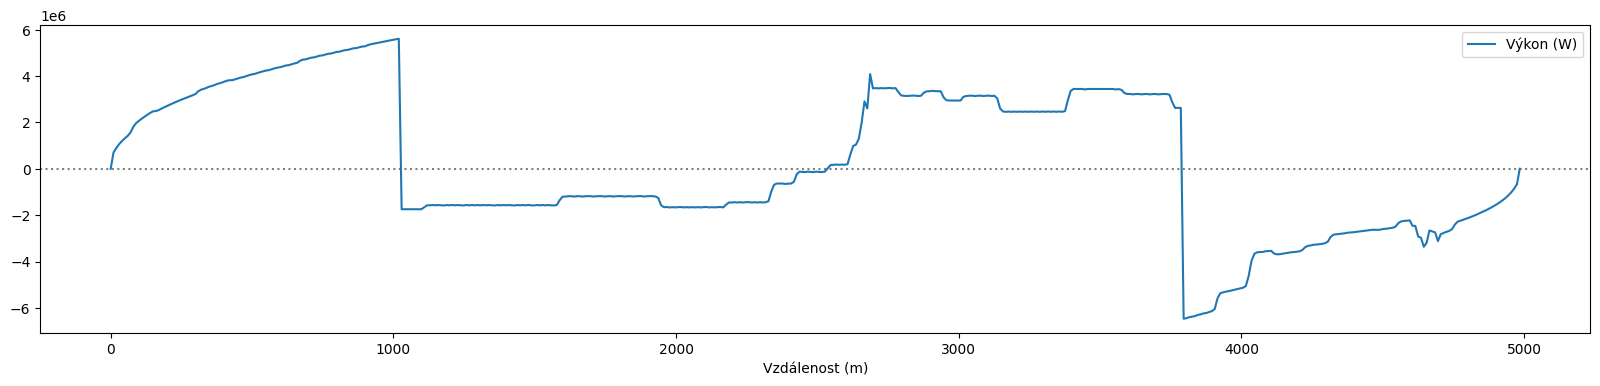

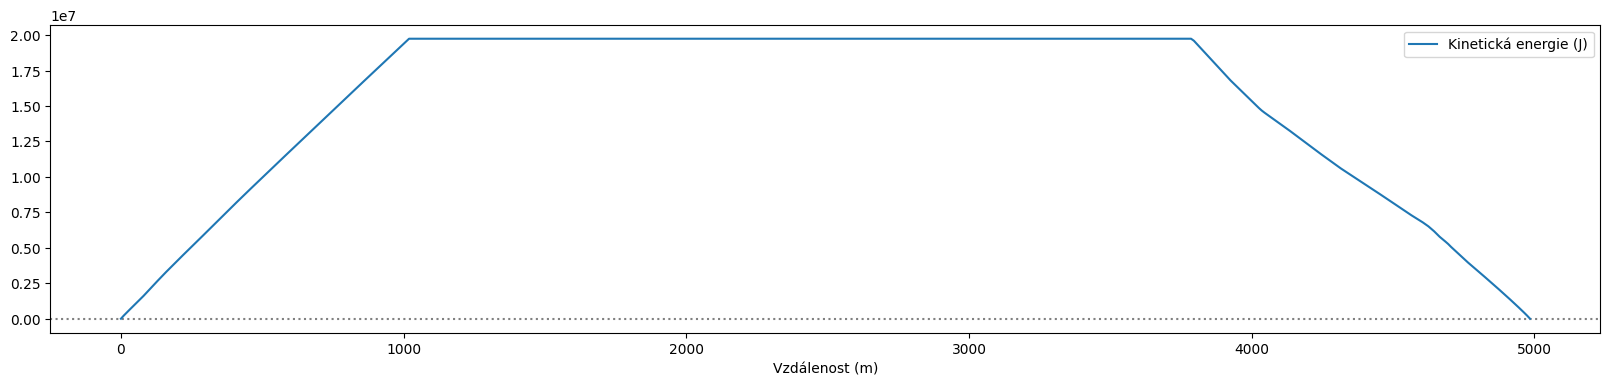

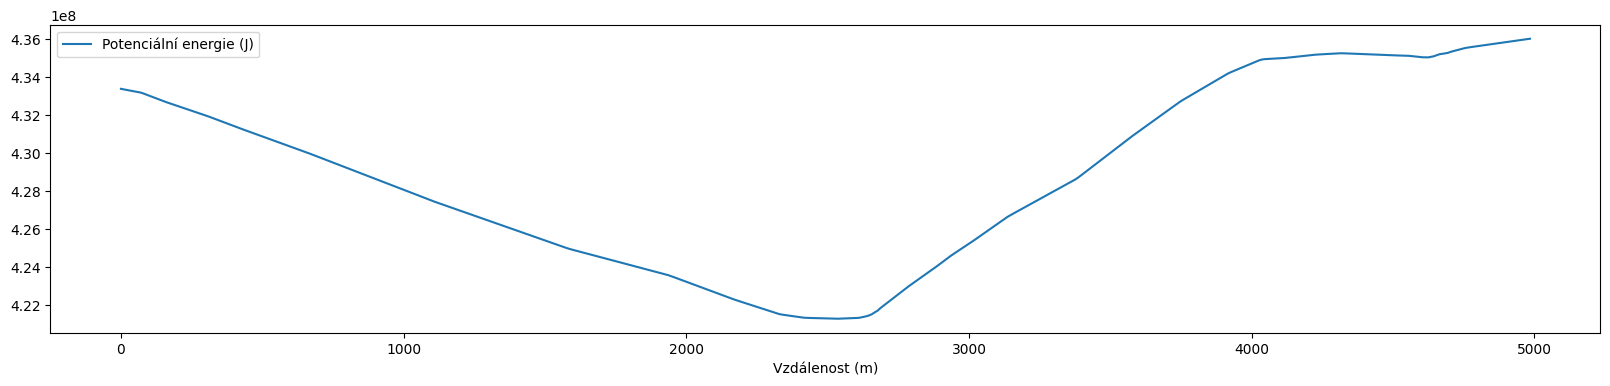

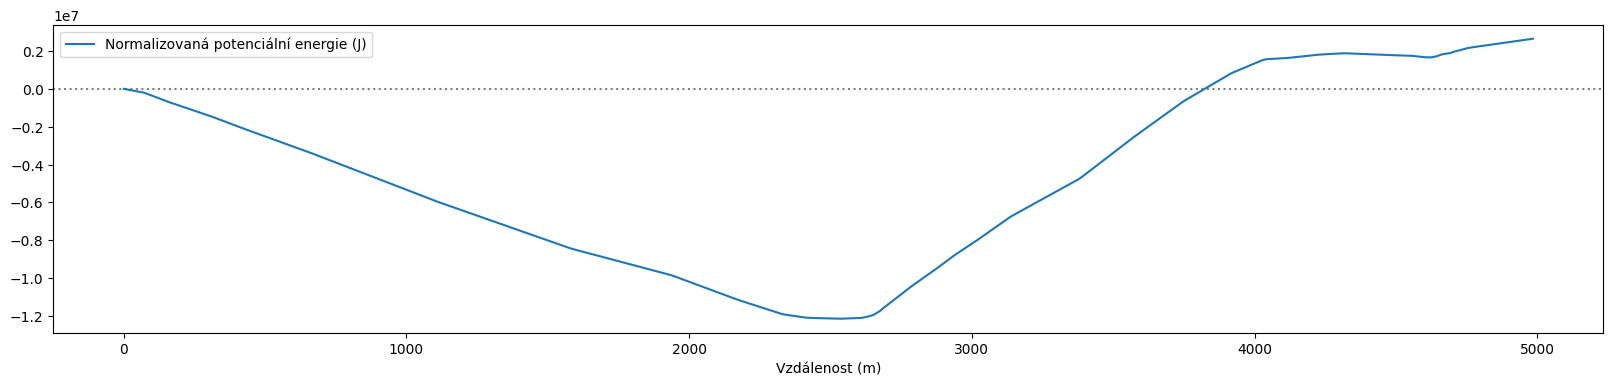

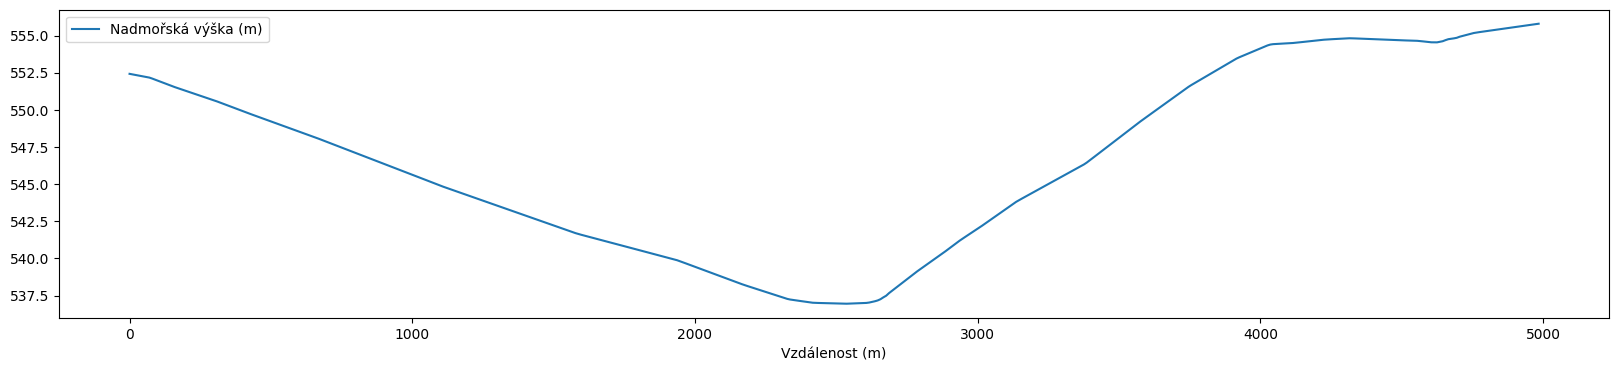

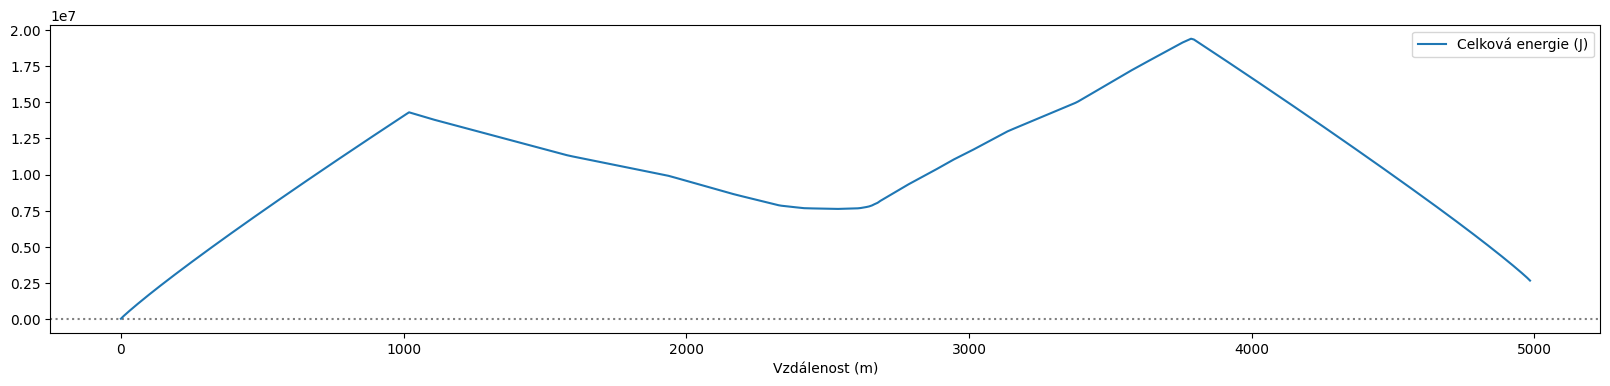

In [34]:
with open("spaced.geojson") as f:
    lines = f.readlines()
    points = parse_points_from_geojson("".join(lines))
    # Remove zeros
    for i in range(len(points)):
        if i == 0:
            continue
        if points[i][2] < points[i-1][2]*0.9:
            points[i] = [points[i][0],points[i][1],points[i-1][2]]

# Show only part of the track
points = points[6000:6500]

max_velocity = 22.22 # m/s
mass_locomotive = 80000 # kg (80 t)
mass_wagon = 1000000 # kg (1000 t)

force_values, dist_values, velocity_values, acceleration_values = get_complete_run_sep(mass_locomotive, mass_wagon, points, max_velocity)
power_values = get_power_raw(force_values, velocity_values)
k_energy_values = get_kinetic_energy(mass, velocity_values)
p_energy_values = get_potential_energy(mass, points)
norm_p_energy_values = get_normalized_potential_energy(p_energy_values)

draw_plot(dist_values, True, {"values": velocity_values, "name": "Rychlost (m/s)", "scatter": False})
draw_plot(dist_values, True, {"values": acceleration_values, "name": "Zrychlení (m/s2)", "scatter": False})
draw_plot(dist_values, True, {"values": power_values, "name": "Výkon (W)", "scatter": False})
draw_plot(dist_values, True, {"values": k_energy_values, "name": "Kinetická energie (J)", "scatter": False})
draw_plot(dist_values, False, {"values": p_energy_values, "name": "Potenciální energie (J)", "scatter": False})
draw_plot(dist_values, True, {"values": norm_p_energy_values, "name": "Normalizovaná potenciální energie (J)", "scatter": False})
draw_plot(dist_values, False, {"values": [x[2] for x in points], "name": "Nadmořská výška (m)", "scatter": False})
draw_plot(dist_values, True, {"values": [k_energy_values[i]+norm_p_energy_values[i] for i in range(len(k_energy_values))], "name": "Celková energie (J)", "scatter": False})

### Průběh po rovině (sanity check)

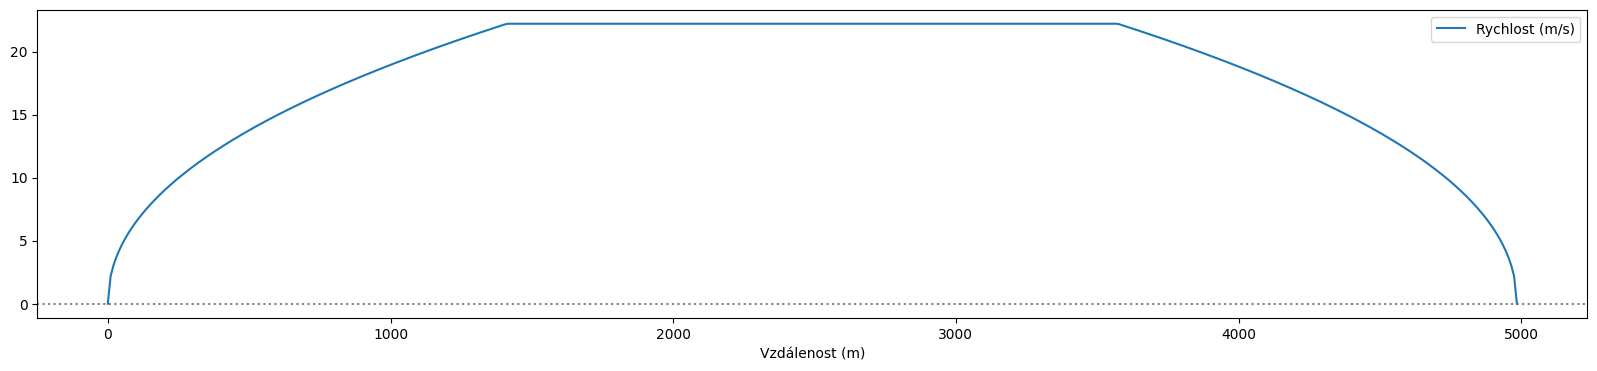

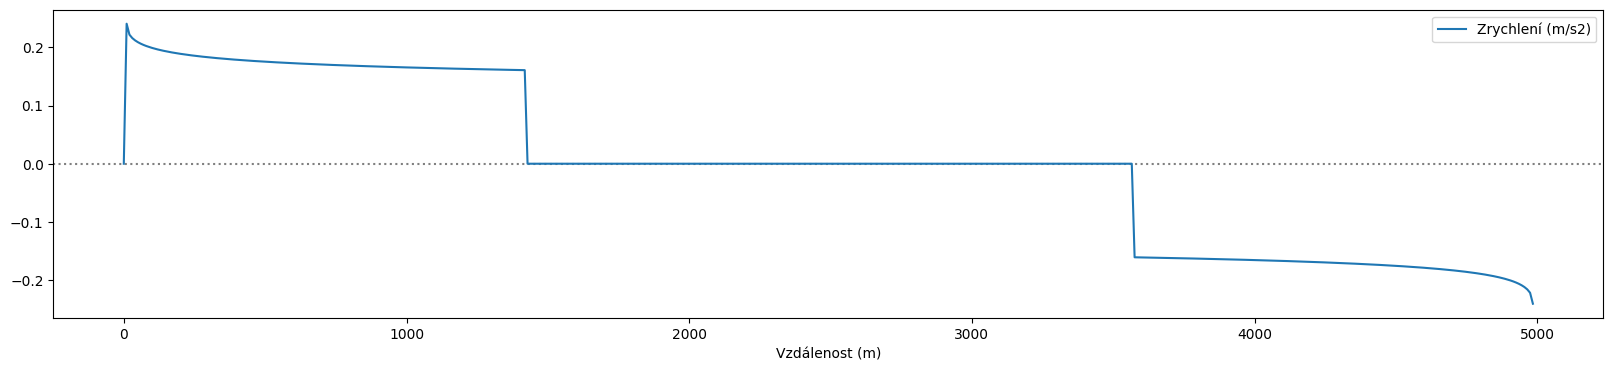

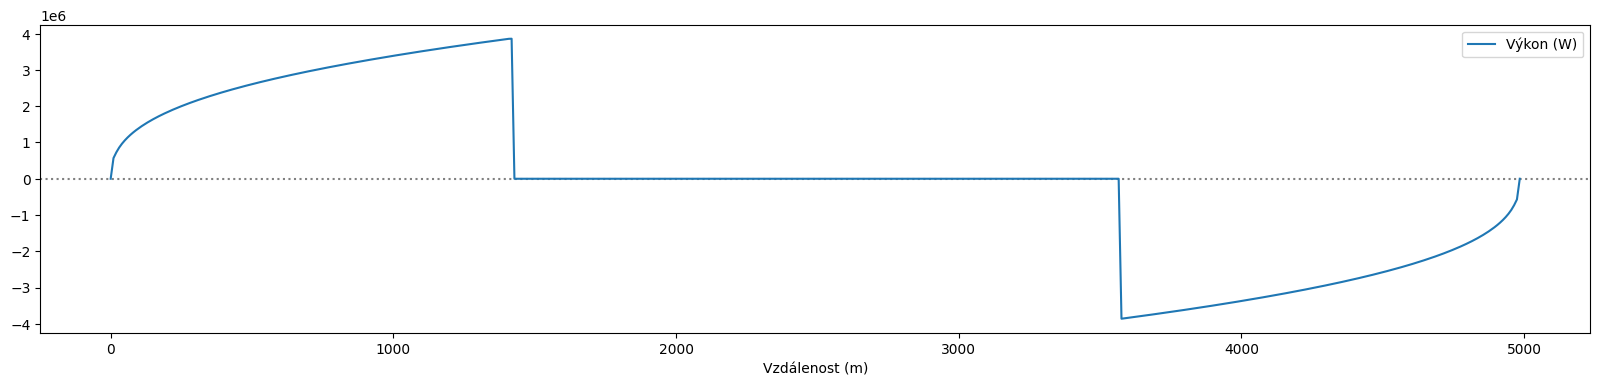

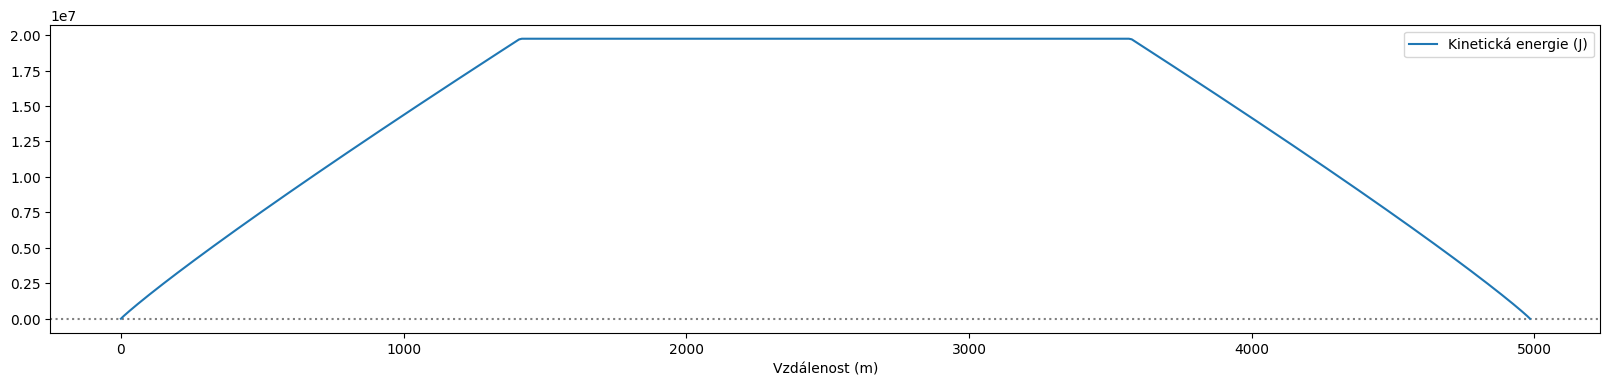

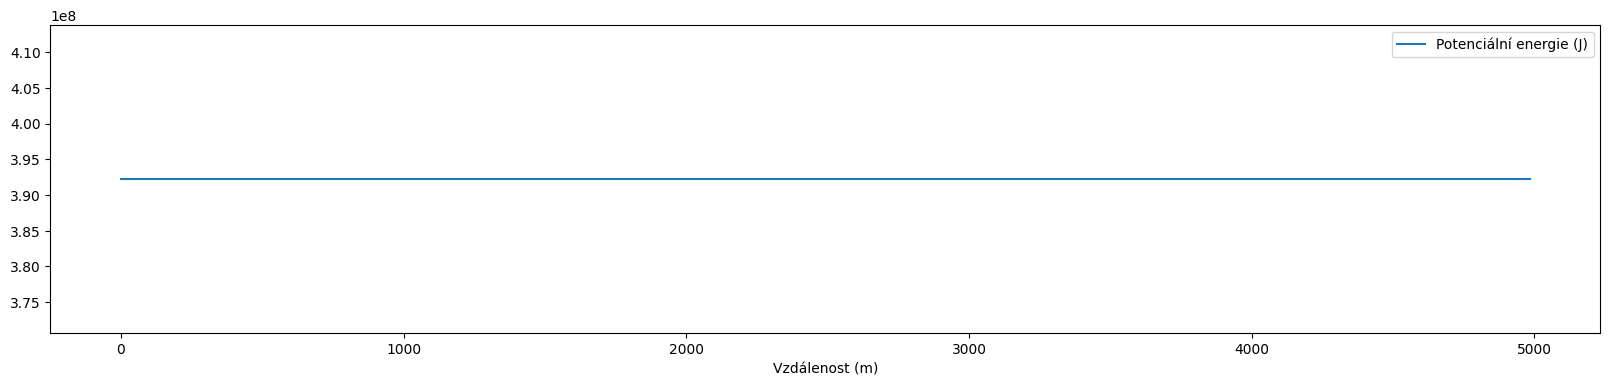

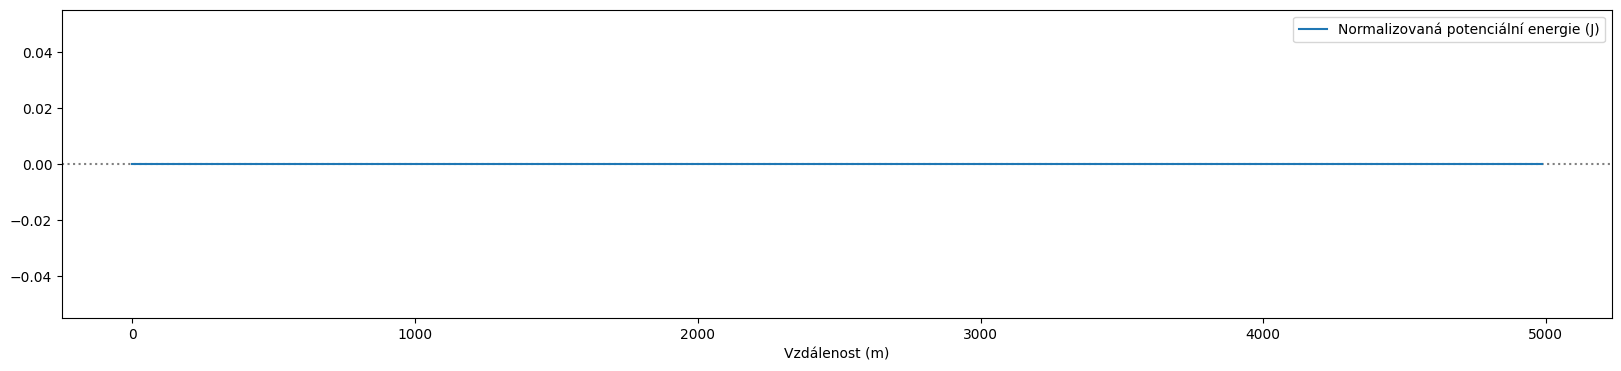

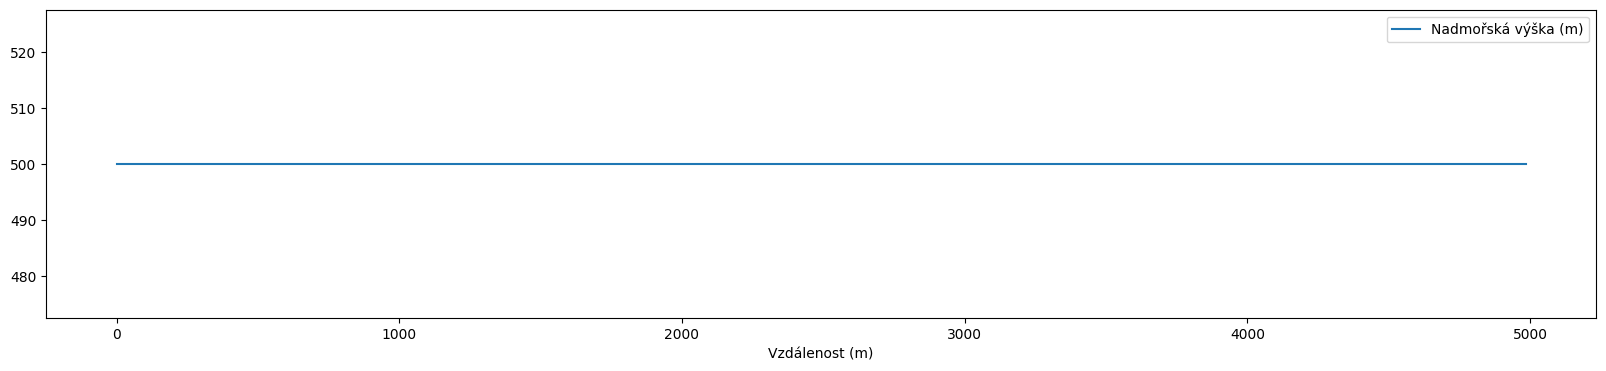

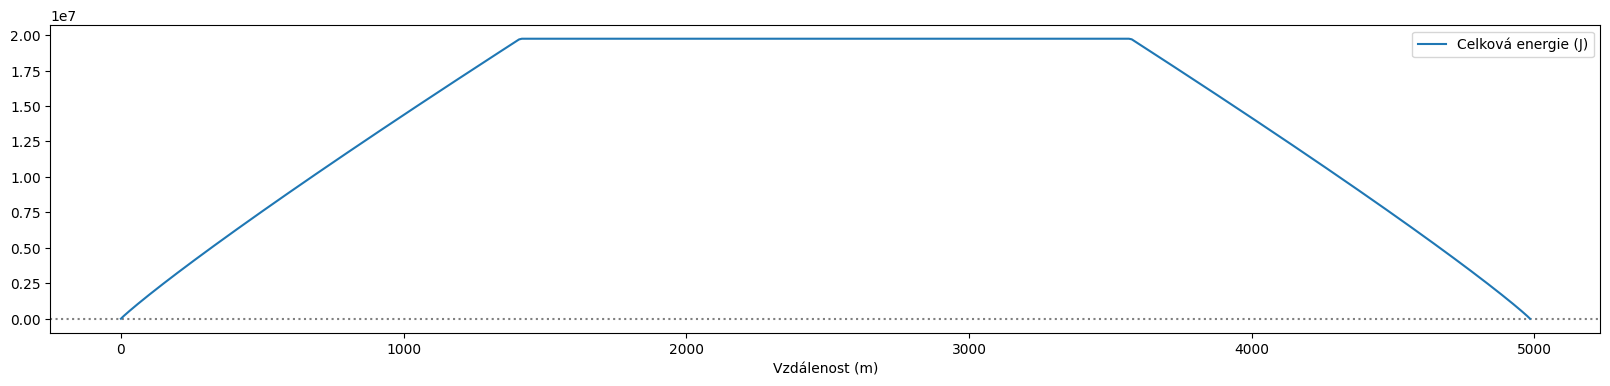

In [35]:
with open("spaced.geojson") as f:
    lines = f.readlines()
    points = parse_points_from_geojson("".join(lines))
    # Remove zeros
    for i in range(len(points)):
        if i == 0:
            continue
        if points[i][2] < points[i-1][2]*0.9:
            points[i] = [points[i][0],points[i][1],points[i-1][2]]

# Show only part of the track
points = points[6000:6500]
# Make the surface FLAT
points = [[x[0],x[1],500] for x in points]

max_velocity = 22.22 # m/s
mass_locomotive = 80000 # kg (80 t)
mass_wagon = 1000000 # kg (1000 t)

force_values, dist_values, velocity_values, acceleration_values = get_complete_run_sep(mass_locomotive, mass_wagon, points, max_velocity)
power_values = get_power_raw(force_values, velocity_values)
k_energy_values = get_kinetic_energy(mass, velocity_values)
p_energy_values = get_potential_energy(mass, points)
norm_p_energy_values = get_normalized_potential_energy(p_energy_values)

draw_plot(dist_values, True, {"values": velocity_values, "name": "Rychlost (m/s)", "scatter": False})
draw_plot(dist_values, True, {"values": acceleration_values, "name": "Zrychlení (m/s2)", "scatter": False})
draw_plot(dist_values, True, {"values": power_values, "name": "Výkon (W)", "scatter": False})
draw_plot(dist_values, True, {"values": k_energy_values, "name": "Kinetická energie (J)", "scatter": False})
draw_plot(dist_values, False, {"values": p_energy_values, "name": "Potenciální energie (J)", "scatter": False})
draw_plot(dist_values, True, {"values": norm_p_energy_values, "name": "Normalizovaná potenciální energie (J)", "scatter": False})
draw_plot(dist_values, False, {"values": [x[2] for x in points], "name": "Nadmořská výška (m)", "scatter": False})
draw_plot(dist_values, True, {"values": [k_energy_values[i]+norm_p_energy_values[i] for i in range(len(k_energy_values))], "name": "Celková energie (J)", "scatter": False})

## Závěrečné poznámky ke třetí iteraci

Tady se v podstatě jenom funkce upravily tak, aby počítaly síly separátně pro hmotnost lokomotivy a hmotnost vagónů:
- U lokomotivy nás zajímá tečná síla a působení gravitačního zrychlení
- U vagónů nás zajímá pouze gravitační zrychlení (protože vagóny vlak netlačí kupředu)

<br>
<hr>
<br>
<a id="ctvrta_iterace"></a>

## Čtvrtá iterace - Počítání s jízdními odpory (13.2.2023)

<a href="#teleport">
    <button>Zpět na teleport</button>
</a>

### Plán
- Zakomponovat do výpočtů měrný vozidlový jízdní odpor ✅
- Udržet separátní linku pro lokomotivy a vagóny ✅
- Oddělit výpočet finální síly (tažná síla a všechny externí vlivy dohromady) a výpočet síly působené (pouze *záměrně* působená síla, která ultimátně přispívá ke spotřebě) ✅

### Korekce (opraveno i v předchozích iteracích)
- Pokud vlak dosáhne své rychlosti, tak nebude působící síla (pokud nepočítáme jízdní odpory) nulová, ale je třeba určitou sílu vyvíjet pro udržení této rychlosti, protože se vlak pohybuje na nakloněné rovině $\rightarrow$ toto samozřejmě neplatí pro kompletně rovnou trať

In [36]:
def calc_running_resistance(velocity, a=1.35, b=0.0008, c=0.00033):
    if velocity == 0:
        a = 0
    velocity_in_kph = velocity*3.6
    return a+b*velocity_in_kph+c*velocity_in_kph**2

> Vzorec pro výpočet měrného vozidlového odporu: $ o_v = a+bv+cv^2 $ [N/kN]

In [37]:
def calc_running_resistance_force(velocity, mass, a=1.35, b=0.0008, c=0.00033):
    # print(velocity, mass)
    resistance = calc_running_resistance(velocity, a, b, c)
    mass_in_tons = mass/1000
    return resistance * mass_in_tons * G_TO_MS2 

> Vzorec pro výpočet síly z měrného vozidlového odporu: $ O_v = o_v\cdot m\cdot g $ [N]

In [38]:
def get_ramp_up_res(mass_locomotive, mass_wagon, points, max_velocity, acceleration_limit=None):
    force_values = [0]
    exerted_force_values = [0]
    velocity_values = [0]
    dist_values = [0]
    acceleration_values = [0]
    velocity_reached = False
    
    for i in range(len(points)-1):
        immediate_distance = calc_distance_two_points(points[i], points[i+1])
        angle_cos, slope_distance = get_elevation_slope_cos(points[i], points[i+1], immediate_distance)
        angle_sin = get_elevation_slope_sin(points[i], points[i+1], immediate_distance)[0]
        
        # Forces on locomotive
        tangential_force_l = calc_tangential_force(mass_locomotive, angle_cos, velocity_values[-1])
        parallel_g_force_l = calc_parallel_g_force(mass_locomotive, angle_sin)
        running_res_force_l = calc_running_resistance_force(velocity_values[-1], mass_locomotive)
        
        # Forces on wagon
        parallel_g_force_w = calc_parallel_g_force(mass_wagon, angle_sin)
        running_res_force_w = calc_running_resistance_force(velocity_values[-1], mass_wagon)
        
        if not velocity_reached:
            # Is it incline/decline?
            if points[i+1][2] - points[i][2] > 0: # Incline
                final_force = tangential_force_l - parallel_g_force_l - parallel_g_force_w - running_res_force_l - running_res_force_w
            else: # Decline
                final_force = tangential_force_l + parallel_g_force_l + parallel_g_force_w - running_res_force_l - running_res_force_w
            acceleration = calc_acceleration(final_force, mass_locomotive+mass_wagon)
            # NOTE: If acceleration exceeds the limit, we'll just cap it
            # TODO: Check if we can cap acceleration from tangential force separately
            if acceleration_limit is not None and acceleration > acceleration_limit:
                acceleration = acceleration_limit
            new_velocity = calc_velocity(acceleration, slope_distance, velocity_values[-1])
            if new_velocity >= max_velocity:
                new_velocity = max_velocity
                velocity_reached = True
            exerted_force = tangential_force_l
        else:
            # NOTE: when surface is not flat, we need to exert force to keep our speed
            # Is it incline/decline?
            if points[i+1][2] - points[i][2] > 0: # Incline
                final_force = parallel_g_force_l + parallel_g_force_w + running_res_force_l + running_res_force_w
            else: # Decline
                final_force = -parallel_g_force_l - parallel_g_force_w + running_res_force_l + running_res_force_w
            acceleration = 0 # NOTE: If no change in speed, acceleration is ZERO
            exerted_force = final_force
        force_values.append(final_force)
        exerted_force_values.append(exerted_force)
        velocity_values.append(new_velocity)
        dist_values.append(dist_values[-1]+slope_distance)
        acceleration_values.append(acceleration)
    return force_values, exerted_force_values, dist_values, velocity_values, acceleration_values

> Tato funkce dostane na vstupu hmotnost lokomotivy, body trati, maximální rychlost a limit zrychlení, který nesmí být překročen
<br>
> Pro každou po sobě jdoucí dvojici bodů se vypočítá/získá:
> - 2D vzdálenost
> - Vzdálenost s ohledem na změnu elevace + sinus a cosinus úhlu spojeného s elevací
> - Tečná síla působící na nápravu lokomotivy, síla vznikající vlivem gravitace působící rovnoběžně s povrchem (pro lokomotivu i vagóny) a síla vznikající působením vozidlového odporu $\rightarrow$ to dá součtem/rozdílem maximální sílu působící na rozjezd vlaku
> - Zrychlení v daném bodě
> - Rychlost na základě získaného zrychlení

> Kde se tento přístup jeví jako naivní (**aktualizace z třetí iterace**):
> - <s>Zrychlení je konstantní po celou dobu rozjezdu a při dosažení maximální rychlosti skočí na nulu</s> $\rightarrow$ Při dosažení maximální rychlosti stále skočí na nulu (nedochází ke změně rychlosti), ale už není konstantní při rozjezdu/brždění
> - <s>Tažná sílá se počítá z celé hmotnosti</s> $\rightarrow$ Hmotnost je rozdělena na lokomotivu, pro kterou se tažná síla počítá, a na vagóny, u kterých se počítá pouze vliv gravitačního zrychlení
> - Vlak na začátku zrychluje a po dosažení maximální rychlosti na trati se jí perfektně drží
> - <s>Tření je imaginární koncept</s> Toto bylo snad do jisté míry napraveno přidáním odporu
> - **Odpor z jízdy obloukem se nezapočítává (zatím)**

In [39]:
def get_ramp_down_res(mass_locomotive, mass_wagon, points, max_velocity, acceleration_limit=None):
    end_force = [0]
    end_exerted_force = [0]
    end_velocity = [0]
    deceleration_values = [0]
    for i in range(len(points)-1,0,-1):
        immediate_distance = calc_distance_two_points(points[i], points[i-1])
        angle_cos, slope_distance = get_elevation_slope_cos(points[i-1], points[i], immediate_distance)
        angle_sin = get_elevation_slope_sin(points[i-1], points[i], immediate_distance)[0]
        
        # Forces on locomotive
        tangential_force_l = calc_tangential_force(mass_locomotive, angle_cos, end_velocity[-1])
        parallel_g_force_l = calc_parallel_g_force(mass_locomotive, angle_sin)
        running_res_force_l = calc_running_resistance_force(end_velocity[-1], mass_locomotive)
        
        # Forces on wagon
        parallel_g_force_w = calc_parallel_g_force(mass_wagon, angle_sin)
        running_res_force_w = calc_running_resistance_force(end_velocity[-1], mass_wagon)
        
        # Is it incline/decline?
        if points[i-1][2] - points[i][2] > 0: # Incline
            final_force = tangential_force_l - parallel_g_force_l - parallel_g_force_w - running_res_force_l - running_res_force_w
        else: # Decline
            final_force = tangential_force_l + parallel_g_force_l + parallel_g_force_w - running_res_force_l - running_res_force_w
        exerted_force = tangential_force_l
        acceleration = calc_acceleration(final_force, mass_locomotive+mass_wagon)
        # NOTE: If acceleration exceeds the limit, we'll just cap it
        if acceleration_limit is not None and acceleration > acceleration_limit:
            acceleration = acceleration_limit
        new_velocity = calc_velocity(acceleration, slope_distance, end_velocity[-1])
        if new_velocity >= max_velocity:
            deceleration_values.append(-acceleration) # NOTE: Deceleration has opposite direction
            break
        end_force.append(-final_force) # NOTE: Braking force has opposite direction
        end_exerted_force.append(-exerted_force)
        end_velocity.append(new_velocity)
        deceleration_values.append(-acceleration) # NOTE: Deceleration has opposite direction
    return end_force, end_exerted_force, end_velocity, deceleration_values[1::]

> Tato funkce počítá působící sílu, rychlost a zrychlení (resp. *zpomalení*) a to pro posledních několik metrů cesty
<br>
> Působící síla se skládá u lokomotivy z tečné síly, složky gravitační síly a síly způsobené vozidlovým odporem (u vagonu stejné, kromě tečné síly) 
<br>
> Funguje obdobně jako předchozí a slouzí pouze k doplnění brždění vlaku

> Kde se tento přístup jeví jako naivní:
> - Rozjíždění tady funguje stejně jako zpomalování - typicky na brždění působí více náprav, zatímco u rozjezdu tlačí vlak pouze lokomotiva (jedna nebo více)

In [40]:
def get_complete_run_res(mass_locomotive, mass_wagon, points, max_velocity, acceleration_limit=None):
    force_values, exerted_force_values, dist_values, velocity_values, acceleration_values = get_ramp_up_res(mass_locomotive, mass_wagon, points, max_velocity, acceleration_limit)
    end_force, end_exerted_force, end_velocity, deceleration_values = get_ramp_down_res(mass_locomotive, mass_wagon, points, max_velocity, acceleration_limit)
    for i in range(len(end_velocity)):
        force_values[-i-1] = end_force[i]
        exerted_force_values[-i-1] = end_exerted_force[i]
        velocity_values[-i-1] = end_velocity[i]
        acceleration_values[-i-1] = deceleration_values[i]
    return force_values, exerted_force_values, dist_values, velocity_values, acceleration_values

> Tato funkce pouze vezme hodnoty ze dvou předchozích a udělá z nich jeden celek
<br>
> Na konci je tedy mimo jiné možné vygenerovat graf rychlosti po celé trati, kde vlak nejdřívě zrychluje, potom urdžuje konstantní rychlost a následně zpomalí

In [41]:
def get_energy_from_force(force_values, dist_values):
    to_return = []
    running_sum = 0
    for i in range(len(force_values)):
        if i > 0:
            cur_dist = dist_values[i] - dist_values[i-1]
        else:
            cur_dist = dist_values[i]
        running_sum += force_values[i]*cur_dist
        prev_dist = dist_values[i]
        to_return.append(running_sum)
    return to_return

> Tato funkce na vstupu dostane hodnoty působící síly a hodnoty vzdálenosti
<br>
> Vrátí list hodnot energie, kdy každou hodnotu v něm vypočítá podle tohoto vzorce: $ E = F\cdot s $

## Spuštění testovacího případu

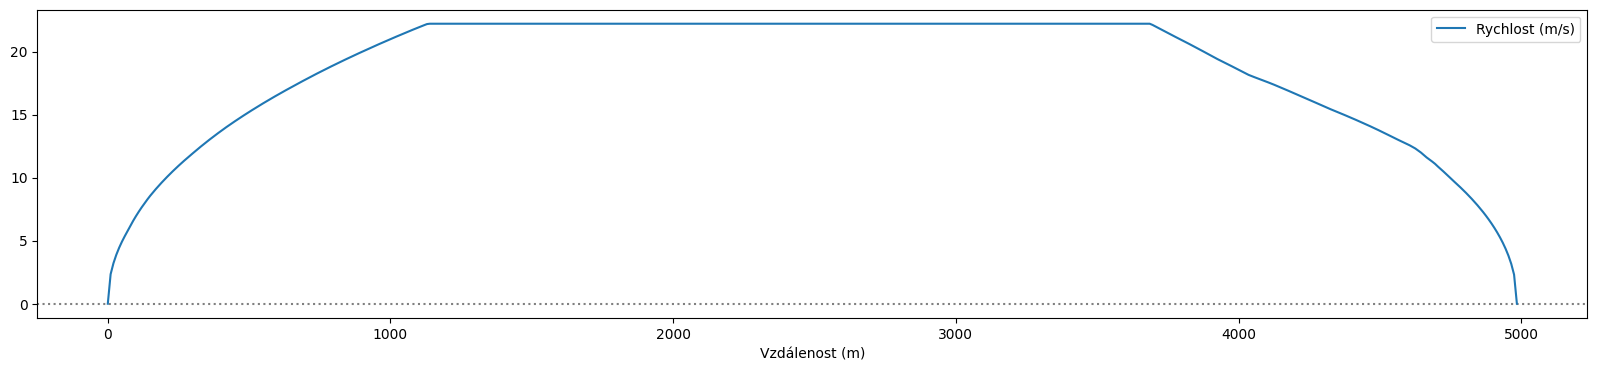

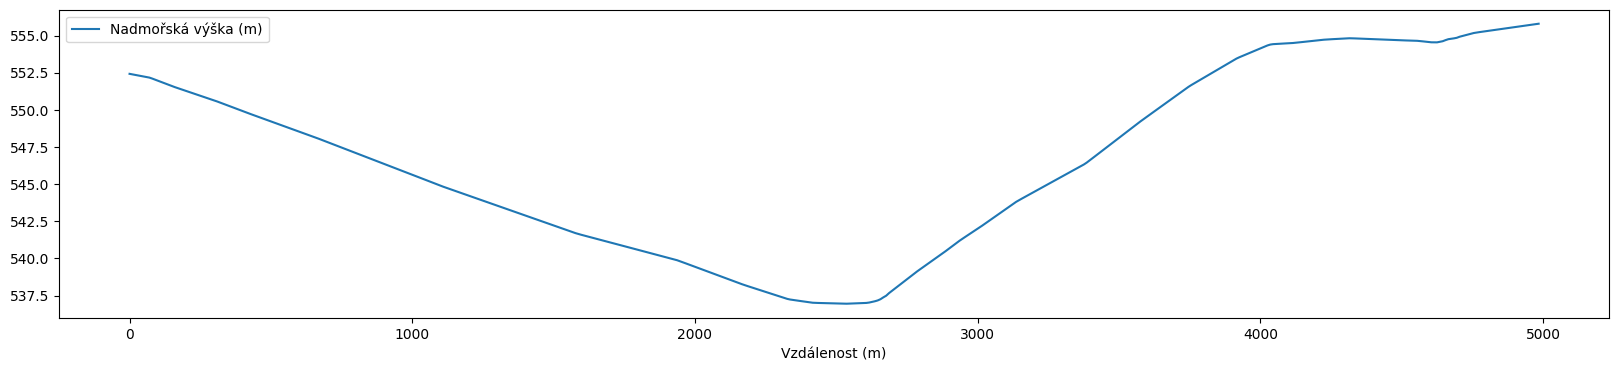

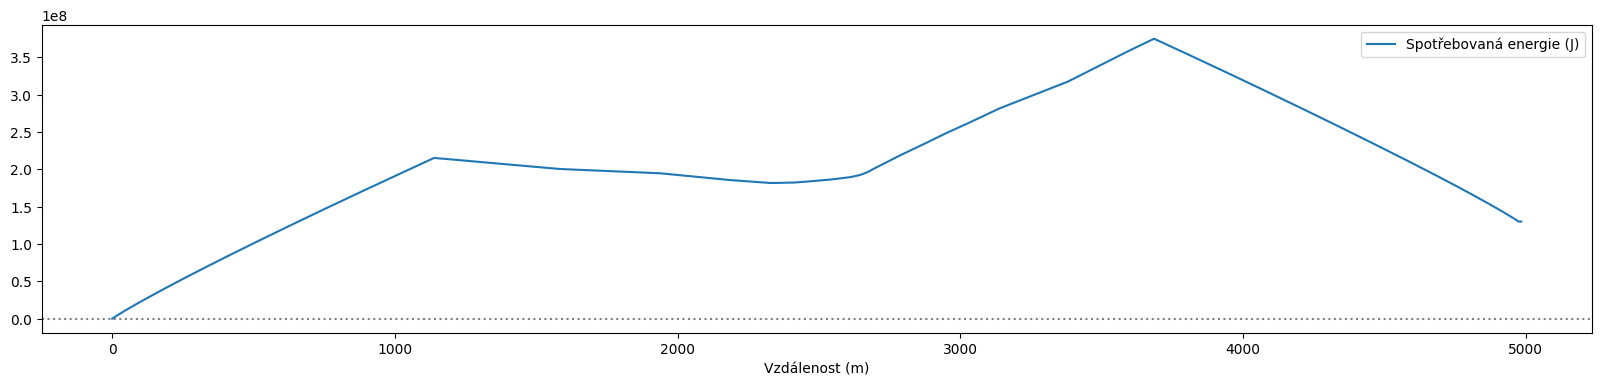

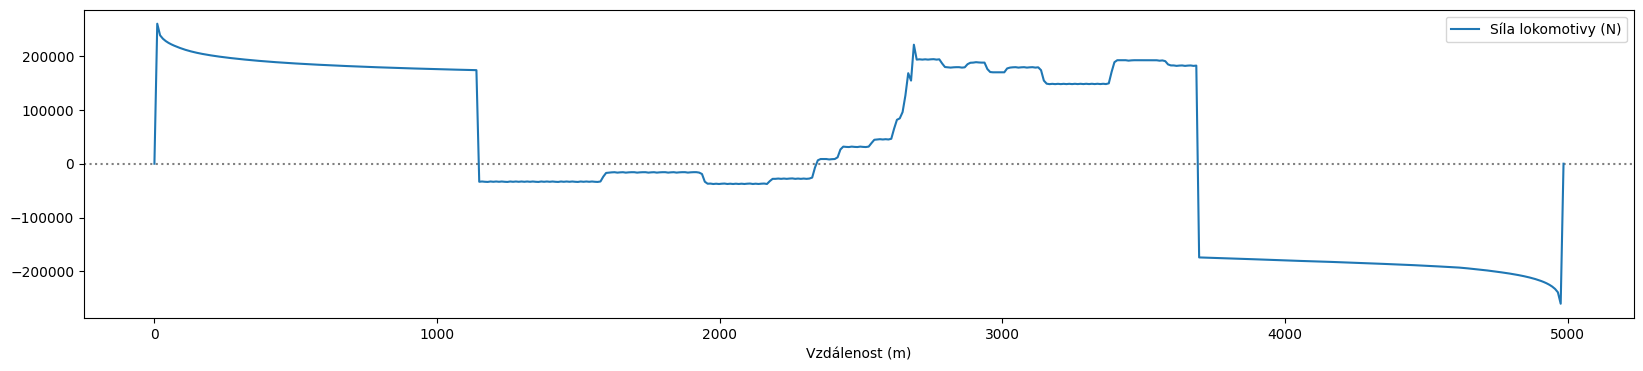

In [42]:
with open("spaced.geojson") as f:
    lines = f.readlines()
    points = parse_points_from_geojson("".join(lines))
    # Remove zeros
    for i in range(len(points)):
        if i == 0:
            continue
        if points[i][2] < points[i-1][2]*0.9:
            points[i] = [points[i][0],points[i][1],points[i-1][2]]

# Show only part of the track
points = points[6000:6500]

max_velocity = 22.22 # m/s
mass_locomotive = 80000 # kg (80 t)
mass_wagon = 1000000 # kg (1000 t)

force_values, exerted_force_values, dist_values, velocity_values, acceleration_values = get_complete_run_res(mass_locomotive, mass_wagon, points, max_velocity)
power_values = get_power_raw(force_values, velocity_values)
power_loco_values = get_power_raw(exerted_force_values, velocity_values)
energy_from_exerted_force = get_energy_from_force(exerted_force_values, dist_values)

draw_plot(dist_values, True, {"values": velocity_values, "name": "Rychlost (m/s)", "scatter": False})
# draw_plot(dist_values, True, {"values": acceleration_values, "name": "Zrychlení (m/s2)", "scatter": False})
# draw_plot(dist_values, True, {"values": power_values, "name": "Výsledný výkon (W)", "scatter": False})
# draw_plot(dist_values, True, {"values": power_loco_values, "name": "Vydaný výkon (W)", "scatter": False})
draw_plot(dist_values, False, {"values": [x[2] for x in points], "name": "Nadmořská výška (m)", "scatter": False})
draw_plot(dist_values, True, {"values": energy_from_exerted_force, "name": "Spotřebovaná energie (J)", "scatter": False})
draw_plot(dist_values, True, {"values": exerted_force_values, "name": "Síla lokomotivy (N)", "scatter": False})

## Závěrečné poznámky ke čtvrté iteraci

V této iteraci se přidal vozidlový odpor ([ODKAZ](https://www.vagony.cz/vagony/energie.html)) a byl pozměněn výpočet energie tak, aby reflektoval pouze působenou sílu (tzn. před započítáním např. gravitační složky a odporů).

K dokonalosti ještě chybí průjezd obloukem.

<br>
<hr>
<br>
<a id="pata_iterace"></a>

## Pátá iterace - Reálná trasa, možná oblouky (ETA 20.2.2023)

<a href="#teleport">
    <button>Zpět na teleport</button>
</a>

### Plán
- Použít reálnou trasu se zastávkami (z DB, Olomouc-Opava) ✅
- Přidat proměnlivou rychlost ✅
    - U rychlosti pouvažovat nad zpětným dopočtem malých ztrát při kalkulaci brždění ✅
    - Sjednotit brždění do zón a na konci ✅
- Zkusit implementovat odpor z jízdy obloukem

### Poznámky
- Funkce zajišťující brždění nesmí až na maximální rychlost, ale na tu dosaženou (vlak na krátké trase nemusí dosáhnout *max_velocity*)

In [43]:
def parse_stations_from_geojson(geojson_raw):
    geojson = json.loads(geojson_raw)
    return geojson["station_orders"]

In [44]:
def parse_max_velocity_from_geojson(geojson_raw):
    geojson = json.loads(geojson_raw)
    velocity_ways_raw = geojson["velocity_ways"]
    max_velocities = []
    for v in velocity_ways_raw:
        max_velocities += [v["velocity"]]*(v["end"]-v["start"]+1)
    return max_velocities

In [45]:
def calc_reverse_acceleration(velocity, distance, init_velocity):
    return (velocity**2-init_velocity**2)/(2*distance)

In [46]:
def calc_force(mass, acceleration):
    return mass*acceleration

In [47]:
def slow_down_to_max_limit(mass_locomotive, mass_wagon, points, velocity_values, max_velocity, slow_point_index, acceleration_limit=None):
    end_force = []
    end_exerted_force = []
    end_velocity = [max_velocity]
    deceleration_values = []
    for i in range(slow_point_index,0,-1):
        immediate_distance = calc_distance_two_points(points[i], points[i-1])
        angle_cos, slope_distance = get_elevation_slope_cos(points[i-1], points[i], immediate_distance)
        angle_sin = get_elevation_slope_sin(points[i-1], points[i], immediate_distance)[0]
        
        # Forces on locomotive
        tangential_force_l = calc_tangential_force(mass_locomotive, angle_cos, end_velocity[-1])
        parallel_g_force_l = calc_parallel_g_force(mass_locomotive, angle_sin)
        running_res_force_l = calc_running_resistance_force(end_velocity[-1], mass_locomotive)
        
        # Forces on wagon
        parallel_g_force_w = calc_parallel_g_force(mass_wagon, angle_sin)
        running_res_force_w = calc_running_resistance_force(end_velocity[-1], mass_wagon)
        
        # Is it incline/decline?
        if points[i-1][2] - points[i][2] > 0: # Incline
            final_force = tangential_force_l - parallel_g_force_l - parallel_g_force_w - running_res_force_l - running_res_force_w
        else: # Decline
            final_force = tangential_force_l + parallel_g_force_l + parallel_g_force_w - running_res_force_l - running_res_force_w
        exerted_force = tangential_force_l
        acceleration = calc_acceleration(final_force, mass_locomotive+mass_wagon)
        # NOTE: If acceleration exceeds the limit, we'll just cap it
        if acceleration_limit is not None and acceleration > acceleration_limit:
            acceleration = acceleration_limit
        new_velocity = calc_velocity(acceleration, slope_distance, end_velocity[-1])
        
        if len(end_force) > 0:
            end_velocity.append(new_velocity)
        end_force.append(-final_force) # NOTE: Braking force has opposite direction
        end_exerted_force.append(-exerted_force)
        deceleration_values.append(-acceleration) # NOTE: Deceleration has opposite direction
        if new_velocity >= velocity_values[i]:
            #####
            new_velocity = velocity_values[i]
            acceleration = calc_reverse_acceleration(new_velocity, slope_distance, end_velocity[-1])
            reverse_force = calc_force(mass_locomotive+mass_wagon, acceleration)
            exerted_force -= final_force-reverse_force
            final_force = reverse_force
            
            end_velocity[-1] = new_velocity
            end_force[-1] = -final_force # NOTE: Braking force has opposite direction
            end_exerted_force[-1] = -exerted_force
            deceleration_values[-1] = -acceleration # NOTE: Deceleration has opposite direction
            #####
            break
    return end_force, end_exerted_force, end_velocity, deceleration_values

In [48]:
def get_ramp_up_five(mass_locomotive, mass_wagon, points, max_velocities, acceleration_limit=None):
    force_values = [0]
    exerted_force_values = [0]
    velocity_values = [0]
    dist_values = [0]
    acceleration_values = [0]
    velocity_reached = False
    
    for i in range(len(points)-1):
        immediate_distance = calc_distance_two_points(points[i], points[i+1])
        angle_cos, slope_distance = get_elevation_slope_cos(points[i], points[i+1], immediate_distance)
        angle_sin = get_elevation_slope_sin(points[i], points[i+1], immediate_distance)[0]
        
        # Forces on locomotive
        tangential_force_l = calc_tangential_force(mass_locomotive, angle_cos, velocity_values[-1])
        parallel_g_force_l = calc_parallel_g_force(mass_locomotive, angle_sin)
        running_res_force_l = calc_running_resistance_force(velocity_values[-1], mass_locomotive)
        
        # Forces on wagon
        parallel_g_force_w = calc_parallel_g_force(mass_wagon, angle_sin)
        running_res_force_w = calc_running_resistance_force(velocity_values[-1], mass_wagon)
        
        if velocity_reached and max_velocities[i] > max_velocities[i-1]:
            velocity_reached = False
        
        if not velocity_reached:
            # Is it incline/decline?
            if points[i+1][2] - points[i][2] > 0: # Incline
                final_force = tangential_force_l - parallel_g_force_l - parallel_g_force_w - running_res_force_l - running_res_force_w
            else: # Decline
                final_force = tangential_force_l + parallel_g_force_l + parallel_g_force_w - running_res_force_l - running_res_force_w
            acceleration = calc_acceleration(final_force, mass_locomotive+mass_wagon)
            # NOTE: If acceleration exceeds the limit, we'll just cap it
            if acceleration_limit is not None and acceleration > acceleration_limit:
                acceleration = acceleration_limit
            new_velocity = calc_velocity(acceleration, slope_distance, velocity_values[-1])
            # ###======
            # if max_velocities[i] > max_velocities[i-1] and max_velocities[i-1] < 12:
            #     print(velocity_values, new_velocity, new_velocity > max_velocities[i])
            # ###======
            exerted_force = tangential_force_l
            # Clamp it down, but only if the limit is the same (otherwise we could be clamping by A LOT)
            if new_velocity > max_velocities[i] and max_velocities[i] == max_velocities[i-1]:
                new_velocity = max_velocities[i]
                acceleration = calc_reverse_acceleration(new_velocity, slope_distance, velocity_values[-1])
                reverse_force = calc_force(mass_locomotive+mass_wagon, acceleration)
                exerted_force -= final_force-reverse_force
                final_force = reverse_force
                velocity_reached = True
        else:
            new_velocity = velocity_values[-1]
            # NOTE: when surface is not flat, we need to exert force to keep our speed
            # Is it incline/decline?
            if points[i+1][2] - points[i][2] > 0: # Incline
                final_force = parallel_g_force_l + parallel_g_force_w + running_res_force_l + running_res_force_w
            else: # Decline
                final_force = -parallel_g_force_l - parallel_g_force_w + running_res_force_l + running_res_force_w
            acceleration = 0 # NOTE: If no change in speed, acceleration is ZERO
            exerted_force = final_force
            
        force_values.append(final_force)
        exerted_force_values.append(exerted_force)
        velocity_values.append(new_velocity)
        acceleration_values.append(acceleration)
        dist_values.append(dist_values[-1]+slope_distance)
      
        # print("nv", new_velocity, "mv", max_velocities[i])
        if new_velocity > max_velocities[i]:
            end_force_slow, end_exerted_force_slow, end_velocity_slow, deceleration_values_slow = slow_down_to_max_limit(mass_locomotive, mass_wagon, points, velocity_values, max_velocities[i], i, acceleration_limit)
            for j in range(len(end_velocity_slow)):
                force_values[-j-1] = end_force_slow[j]
                exerted_force_values[-j-1] = end_exerted_force_slow[j]
                velocity_values[-j-1] = end_velocity_slow[j]
                acceleration_values[-j-1] = deceleration_values_slow[j]
        
    return force_values, exerted_force_values, dist_values, velocity_values, acceleration_values

In [49]:
def get_complete_run_five(mass_locomotive, mass_wagon, points, max_velocities, acceleration_limit=None):
    force_values, exerted_force_values, dist_values, velocity_values, acceleration_values = get_ramp_up_five(mass_locomotive, mass_wagon, points, max_velocities, acceleration_limit)
    end_force, end_exerted_force, end_velocity, deceleration_values = slow_down_to_max_limit(mass_locomotive, mass_wagon, points, velocity_values, 0, len(points)-1, acceleration_limit)
    for i in range(len(end_velocity)):
        force_values[-i-1] = end_force[i]
        exerted_force_values[-i-1] = end_exerted_force[i]
        velocity_values[-i-1] = end_velocity[i]
        acceleration_values[-i-1] = deceleration_values[i]
    return force_values, exerted_force_values, dist_values, velocity_values, acceleration_values

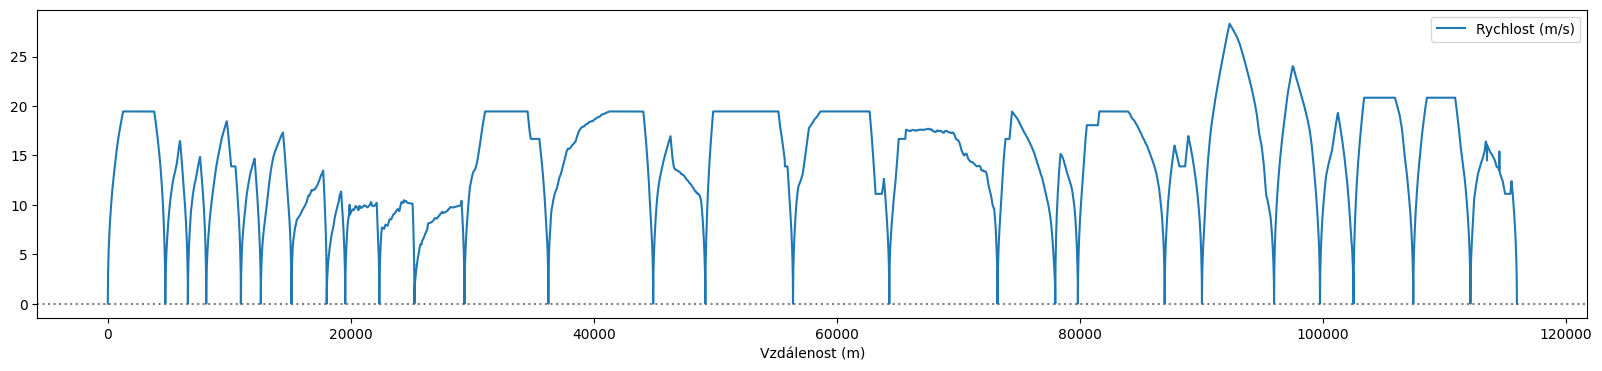

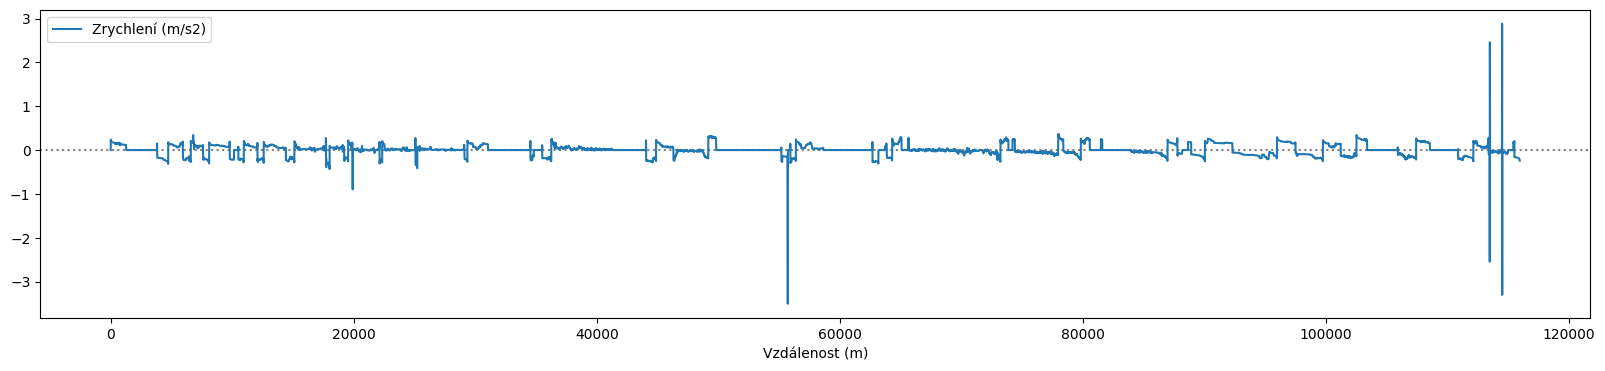

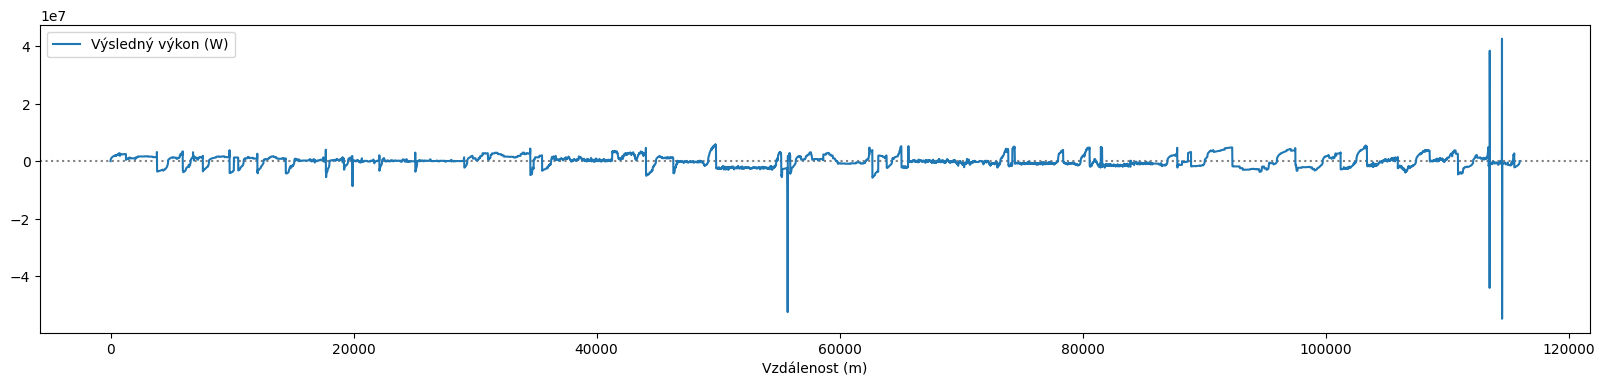

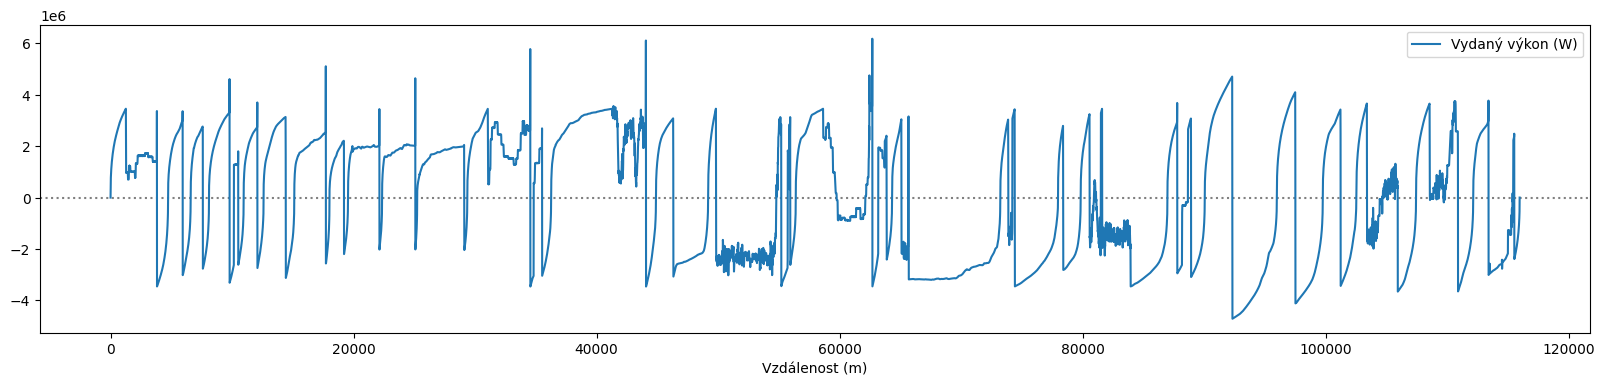

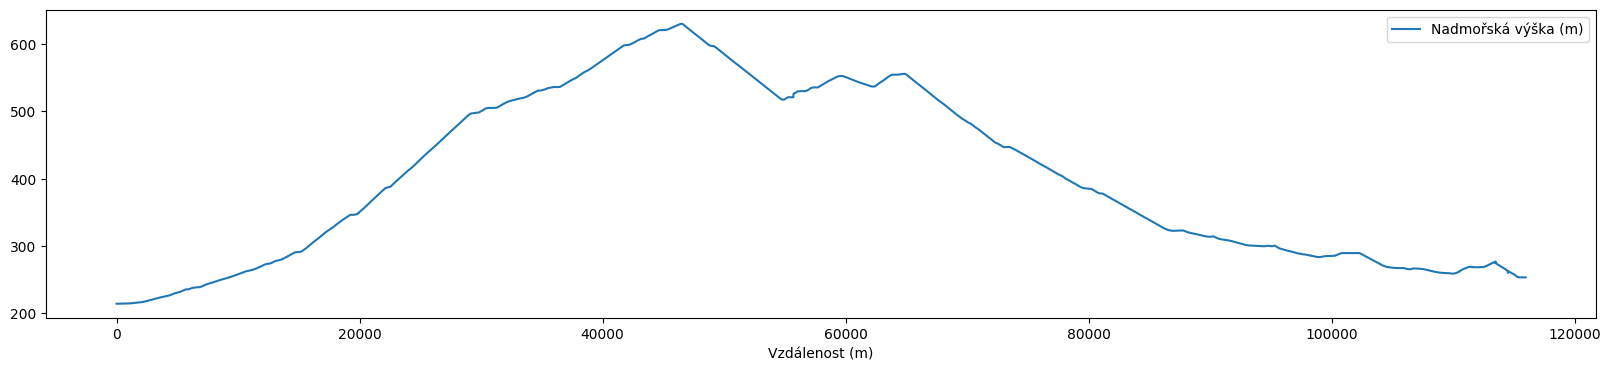

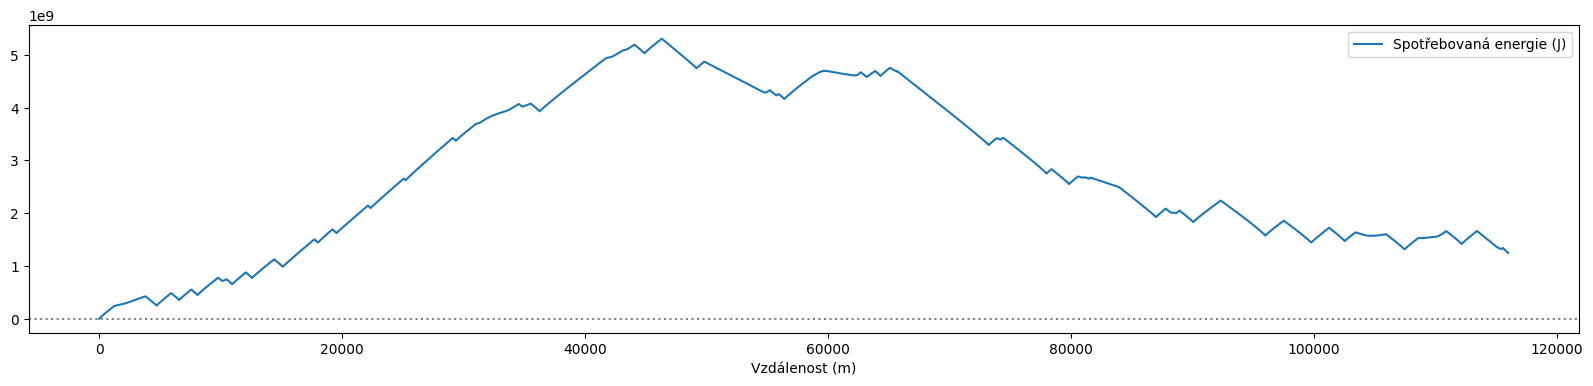

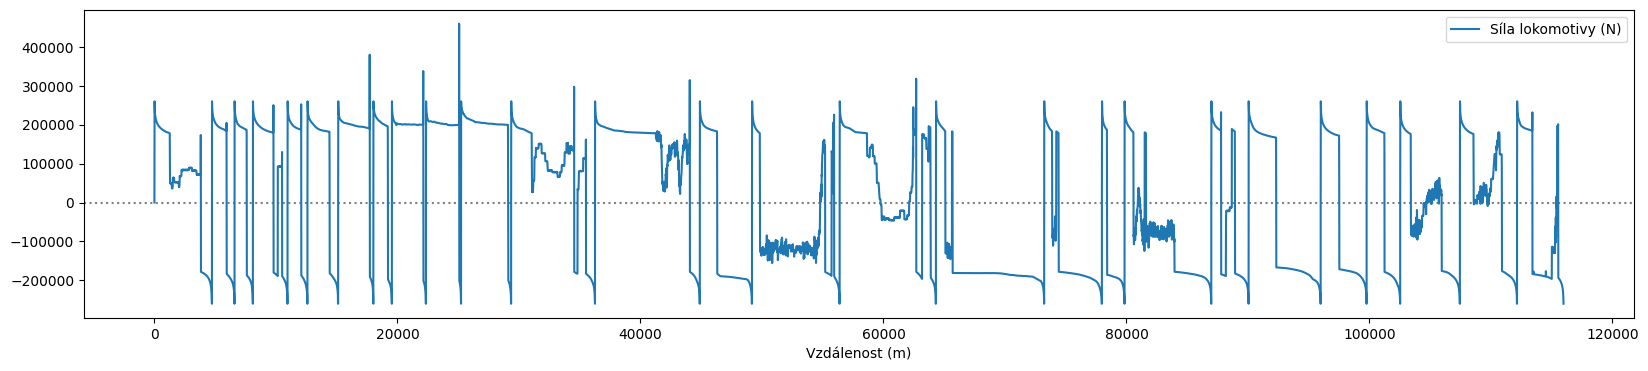

In [50]:
with open("olo-opava.geojson") as f:
    lines = f.readlines()
    geojson_raw = "".join(lines)
    points = parse_points_from_geojson(geojson_raw)
    stations = parse_stations_from_geojson(geojson_raw)
    max_velocities = parse_max_velocity_from_geojson(geojson_raw)
    max_velocities_in_mps = [x/3.6 for x in max_velocities]
    # Remove zeros
    for i in range(len(points)):
        if i == 0:
            continue
        if points[i][2] < points[i-1][2]*0.9:
            points[i] = [points[i][0],points[i][1],points[i-1][2]]

mass_locomotive = 80000 # kg (80 t)
mass_wagon = 1000000 # kg (1000 t)

force_values = []
exerted_force_values = []
dist_values = []
velocity_values = []
acceleration_values = []

# print([(i,x) for i,x in enumerate(power_values) if x >= 81472225])

station_offset = 1
prev_dist_offset = 0
for i in range(len(stations)-1):
    if i == len(stations)-2:
        station_offset = 0
    
    split_points = points[stations[i]:stations[i+1]-station_offset+1]
    split_max_velocities_in_mps = max_velocities_in_mps[stations[i]:stations[i+1]-station_offset+1]
    force_values_s, exerted_force_values_s, dist_values_s, velocity_values_s, acceleration_values_s = get_complete_run_five(mass_locomotive, mass_wagon, split_points, split_max_velocities_in_mps)
    dist_values_s = [d+prev_dist_offset for d in dist_values_s]
    prev_dist_offset = dist_values_s[-1]
    
    force_values += force_values_s
    exerted_force_values += exerted_force_values_s
    dist_values += dist_values_s
    velocity_values += velocity_values_s
    acceleration_values += acceleration_values_s
    
    # draw_plot(dist_values_s, True, {"values": velocity_values_s, "name": "Rychlost (m/s)", "limit_values": split_max_velocities_in_mps, "limit_name": "Maximální rychlost (m/s)", "scatter": False})
    # draw_plot(dist_values_s, False, {"values": [x[2] for x in split_points], "name": "Nadmořská výška (m)", "scatter": False})
    # draw_plot(dist_values_s, True, {"values": get_power_raw(force_values_s, velocity_values_s), "name": "Výsledný výkon (W)", "scatter": False})
    # print("===============", "this was", i, "===============\n")
    
power_values = get_power_raw(force_values, velocity_values)
power_loco_values = get_power_raw(exerted_force_values, velocity_values)
energy_from_exerted_force = get_energy_from_force(exerted_force_values, dist_values)

# print(len(dist_values), len(max_velocities_in_mps), len(points))
    
# draw_plot(dist_values, True, {"values": velocity_values, "name": "Rychlost (m/s)", "limit_values": max_velocities_in_mps, "limit_name": "Maximální rychlost (m/s)", "scatter": False})
draw_plot(dist_values, True, {"values": velocity_values, "name": "Rychlost (m/s)", "scatter": False})
draw_plot(dist_values, True, {"values": acceleration_values, "name": "Zrychlení (m/s2)", "scatter": False})
draw_plot(dist_values, True, {"values": power_values, "name": "Výsledný výkon (W)", "scatter": False})
draw_plot(dist_values, True, {"values": power_loco_values, "name": "Vydaný výkon (W)", "scatter": False})
draw_plot(dist_values, False, {"values": [x[2] for x in points], "name": "Nadmořská výška (m)", "scatter": False})
draw_plot(dist_values, True, {"values": energy_from_exerted_force, "name": "Spotřebovaná energie (J)", "scatter": False})
draw_plot(dist_values, True, {"values": exerted_force_values, "name": "Síla lokomotivy (N)", "scatter": False})

<br>
<hr>
<div style="text-align: center">&#169; Jan Němec 2023</div>